## < 목차 >
- 데이터 EDA
- 코드 6가지 (성능 향상에 따른)
    1) mean centering(중심화) 코드
    2) 코드 2 - Z-Score + Dot product 사용
    3) K 이웃 사용 제거 → 양수 유사도 전체 사용
    4) fallback 방식 추가 + 행렬 계산으로 유사도 계산 시간 단축
    5) IUF 적용
    6) IMDB 데이터 포함 하이브리드 추천

※ 4번 코드를 기준으로 아래 테스트 진행
- significant weight
- 평점 유사도 + 장르 유사도 하이브리드 모델
- 평점 유사도 + 태그 유사도 하이브리드 모델 
    - 최적 파라미터 탐색 코드
- 평점 유사도 + 장르 유사도 + 태그 유사도 하이브리드 모델
    - 최적 파라미터 탐색 코드
- 최적 파라미터 탐색에서 그리드서치 대신 베이지안 서치 사용(평점+장르+태그 모델)
---

# < 데이터 EDA >
1) 데이터 로딩 및 초기 설정         : 경로 설정 및 ratings, movies, tags 파일 로드.
2) 데이터 통합 및 기본 통계 확인    : 데이터 병합 및 총 데이터 개수, 고유 사용자/영화 수 파악.
### 시각화 시작
3) **전체 평점 분포**                  : 사용자들이 부여한 평점의 전반적인 분포 시각화.
4) **사용자/아이템 활동 희소성**        : 사용자별 활동량과 영화별 평가 수의 불균형(Long-tail) 확인.
5) **장르 인기 및 분포**               : 가장 많이 등장하는 주요 장르 순위 파악.
6) **시간 흐름에 따른 평점 변화**       : 연도별 전체 평점 활동량의 추이 확인.
7) **태그 사용 현황**                  : 가장 빈번하게 사용되는 상위 태그 추출.
8) **평가 수와 평점 평균의 상관관계**   : 인기도 편향(Popularity Bias) 여부 확인.
9) **장르 간 상관관계**                : 장르 간의 공존 패턴을 히트맵으로 파악.
10) **사용자별 평점 성향(평균/편차)**   : 사용자마다 다른 기준점을 확인하여 Z-Score 정규화 근거 마련.
11) **영화 개봉 연도별 평점 추이**      : 영화의 시대적 배경(개봉 연도)에 따른 평점 경향성 파악



--- 1. 기본 데이터 통계 ---
총 평점 수: 100836개
고유 사용자 수: 610명
고유 영화 수: 9742개
------------------------------


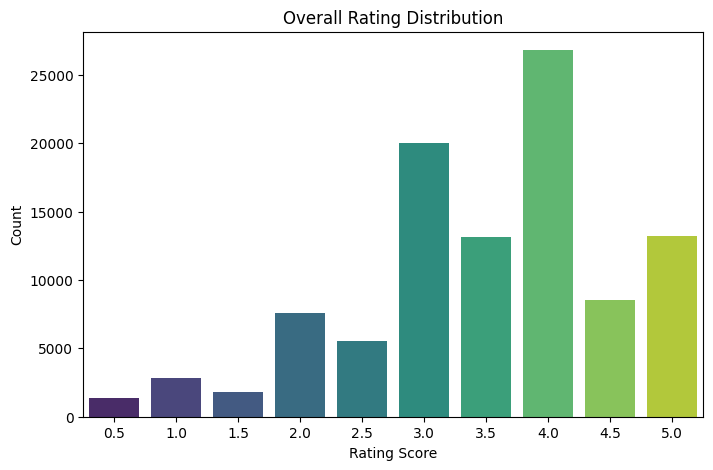

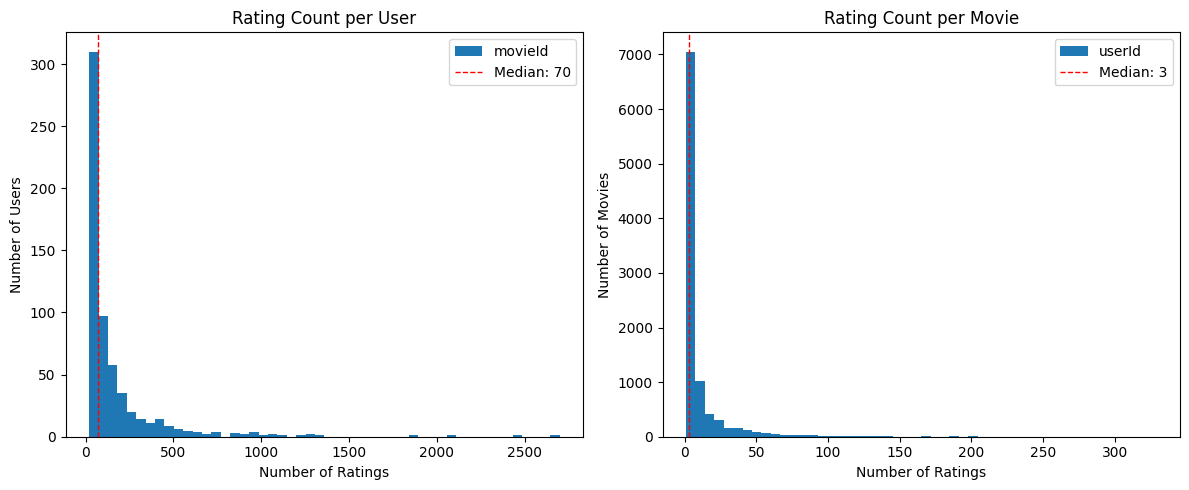

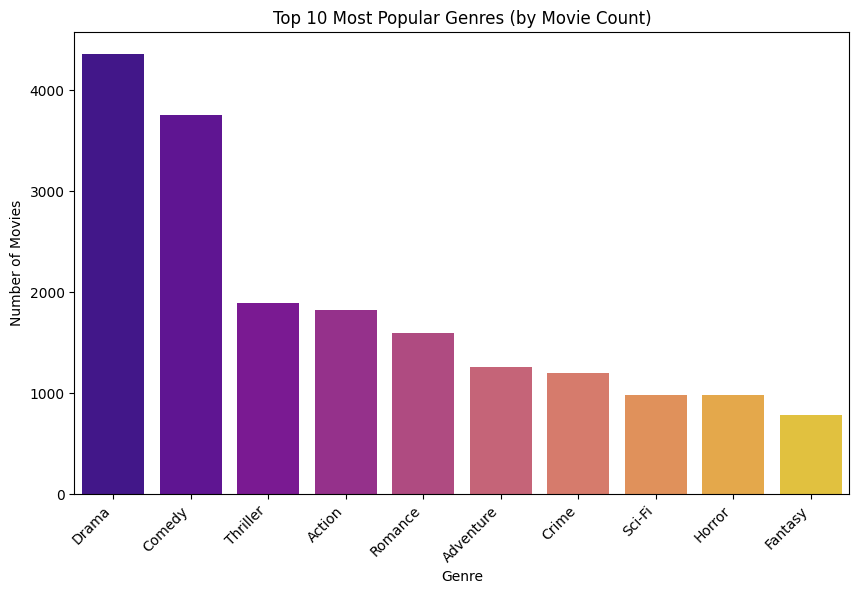

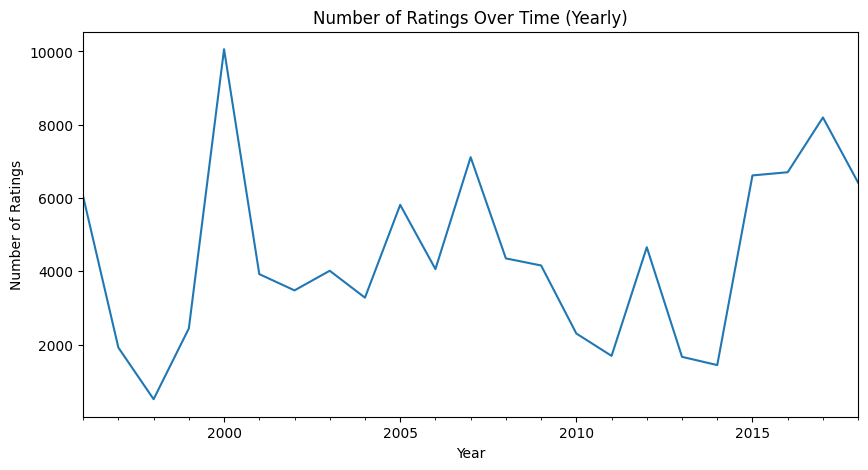

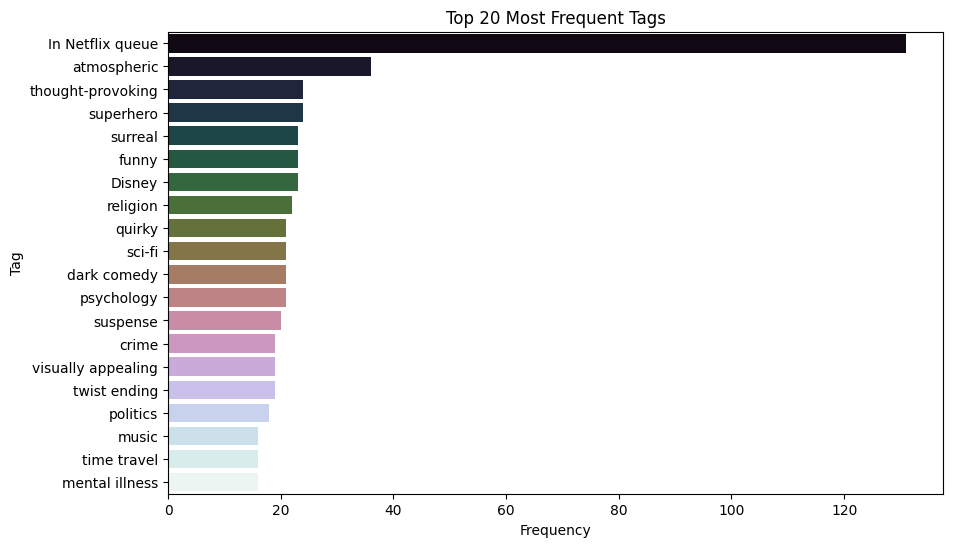

<Figure size 1000x600 with 0 Axes>

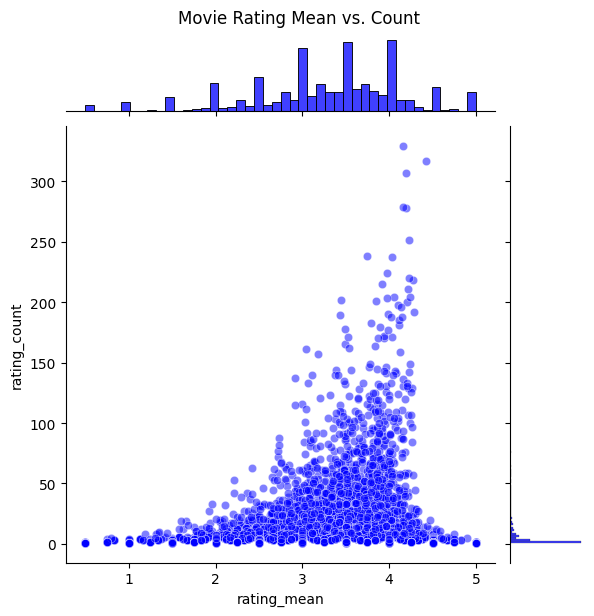

  > Insight: 평가 수가 적은 영화들은 평점이 1점 또는 5점으로 극단적인 경향이 있으며, 평가가 많을수록 3~4점대에 수렴하는지 확인합니다.


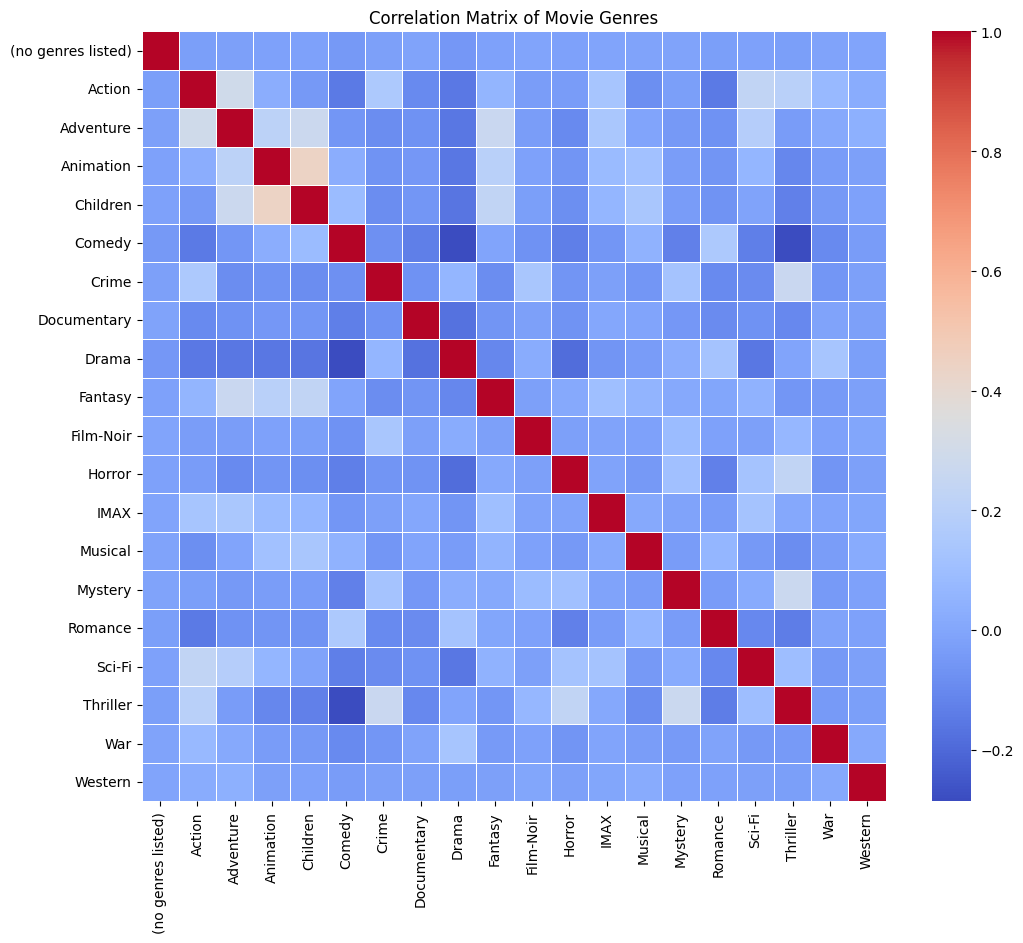

  > Insight: 함께 자주 등장하는 장르(예: Action & Adventure, Animation & Children)를 파악합니다.


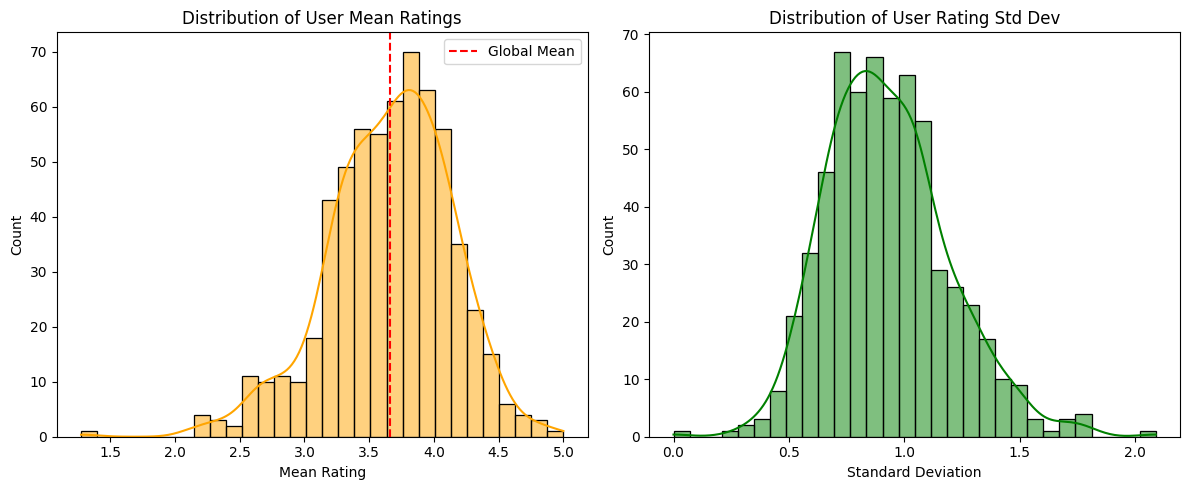

  > Insight: 어떤 사용자는 평균이 4.5점이고, 어떤 사용자는 2.5점일 수 있습니다. 이 차이를 없애기 위해 Z-Score 정규화가 필수적임을 보여줍니다.


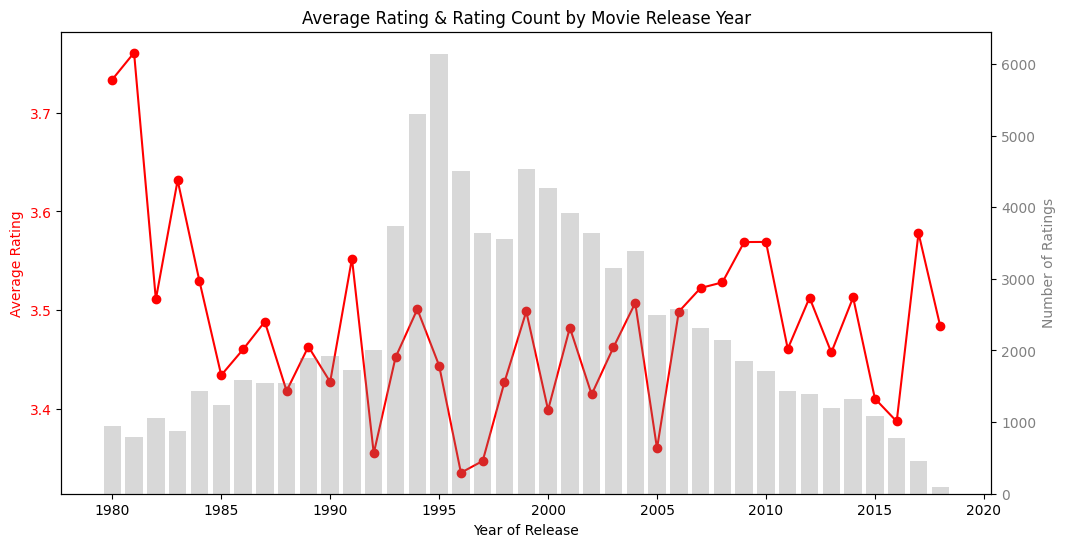

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

# --- 1. 데이터 로딩 및 초기 설정 ---
DATA_PATH = './data' 

try:
    ratings = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv'))
    movies  = pd.read_csv(os.path.join(DATA_PATH, 'movies.csv'))
    # tags 파일은 민지_eda_2에서 사용되었으므로 통합합니다.
    tags    = pd.read_csv(os.path.join(DATA_PATH, 'tags.csv')) 
except FileNotFoundError:
    print("오류: 데이터 파일 (ratings.csv, movies.csv, tags.csv)을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 실제 환경에서는 여기서 raise를 사용하거나 파일 로딩 방식을 수정해야 합니다.
    ratings = pd.DataFrame()
    movies = pd.DataFrame()
    tags = pd.DataFrame()


# --- 2. 데이터 통합 및 기본 정보 확인 ---
if not ratings.empty and not movies.empty:
    # ratings와 movies 데이터 병합
    df_merged = pd.merge(ratings, movies, on='movieId', how='left')
    df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'], unit='s')
    
    # 기본 통계 출력
    print("--- 1. 기본 데이터 통계 ---")
    print(f"총 평점 수: {len(ratings)}개")
    print(f"고유 사용자 수: {ratings['userId'].nunique()}명")
    print(f"고유 영화 수: {movies['movieId'].nunique()}개")
    print("-" * 30)
else:
    print("데이터 로딩 실패로 EDA를 진행할 수 없습니다.")
    exit()

# --- 3. 분석 1: 전체 평점 분포 (Rating Distribution) ---
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Overall Rating Distribution')
plt.xlabel('Rating Score')
plt.ylabel('Count')
plt.show()
# 

# --- 4. 분석 2: 사용자/아이템 활동 희소성 (Sparsity Analysis) ---

# 사용자 활동 (User Activity)
user_counts = ratings.groupby('userId')['movieId'].count()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
user_counts.plot(kind='hist', bins=50, title='Rating Count per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.axvline(user_counts.median(), color='red', linestyle='dashed', linewidth=1, label=f'Median: {user_counts.median():.0f}')
plt.legend()

# 영화 인기 (Item Popularity)
movie_counts = ratings.groupby('movieId')['userId'].count()
plt.subplot(1, 2, 2)
movie_counts.plot(kind='hist', bins=50, title='Rating Count per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.axvline(movie_counts.median(), color='red', linestyle='dashed', linewidth=1, label=f'Median: {movie_counts.median():.0f}')
plt.legend()

plt.tight_layout()
plt.show()
# 


# --- 5. 분석 3: 장르 인기 및 분포 (Genre Popularity) ---

# 장르 분리 및 One-Hot Encoding을 위해 MultiLabelBinarizer 사용
mlb = MultiLabelBinarizer()
df_genres = movies['genres'].str.split('|')
genre_matrix = mlb.fit_transform(df_genres)
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)

# Top 10 장르 계산
genre_counts = genre_df.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.head(10).index, y=genre_counts.head(10).values, palette='plasma')
plt.title('Top 10 Most Popular Genres (by Movie Count)')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

# --- 6. 분석 4: 시간 흐름에 따른 평점 변화 (Temporal Analysis) ---

# 연도별 평점 수 (Trend)
ratings_by_year = df_merged.set_index('timestamp').resample('Y')['rating'].count()
plt.figure(figsize=(10, 5))
ratings_by_year.plot(title='Number of Ratings Over Time (Yearly)')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()

# --- 7. 분석 5: 태그 사용 현황 (Tag Analysis) ---
if not tags.empty:
    # 태그 사용 빈도 분석
    top_tags = tags['tag'].value_counts().head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_tags.index, x=top_tags.values, palette='cubehelix')
    plt.title('Top 20 Most Frequent Tags')
    plt.xlabel('Frequency')
    plt.ylabel('Tag')
    plt.show()

# --- 8. 심화 분석 1: 영화 인기(평가 수)와 평점 평균의 관계 (Popularity vs Quality) ---
# 목적: 평가가 많은 영화가 실제로 평점도 높은지(Popularity Bias) 확인
movie_stats = df_merged.groupby('title').agg({'rating': ['count', 'mean']})
movie_stats.columns = ['rating_count', 'rating_mean']

plt.figure(figsize=(10, 6))
sns.jointplot(x='rating_mean', y='rating_count', data=movie_stats, alpha=0.5, color='b')
plt.suptitle('Movie Rating Mean vs. Count', y=1.02)
plt.show()

print("  > Insight: 평가 수가 적은 영화들은 평점이 1점 또는 5점으로 극단적인 경향이 있으며, 평가가 많을수록 3~4점대에 수렴하는지 확인합니다.")

# --- 9. 심화 분석 2: 장르 간 상관관계 히트맵 (Genre Correlation) ---
# 목적: 장르 간의 공존 관계를 파악하여 콘텐츠 기반 필터링에 힌트 얻기
# (이전 코드의 genre_df를 활용)
genre_corr = genre_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(genre_corr, cmap='coolwarm', linewidths=.5, annot=False) # annot=True로 하면 숫자가 너무 복잡할 수 있음
plt.title('Correlation Matrix of Movie Genres')
plt.show()

print("  > Insight: 함께 자주 등장하는 장르(예: Action & Adventure, Animation & Children)를 파악합니다.")

# --- 10. 심화 분석 3: 사용자별 평점 부여 성향 (User Rating Behavior) ---
# 목적: 사용자마다 평균 점수가 얼마나 다른지 확인 -> Z-Score 정규화가 왜 필요한지 시각적 증명
user_agg = ratings.groupby('userId')['rating'].agg(['mean', 'std'])

plt.figure(figsize=(12, 5))

# 사용자별 평균 평점 분포
plt.subplot(1, 2, 1)
sns.histplot(user_agg['mean'], bins=30, kde=True, color='orange')
plt.title('Distribution of User Mean Ratings')
plt.xlabel('Mean Rating')
plt.axvline(user_agg['mean'].mean(), color='red', linestyle='--', label='Global Mean')
plt.legend()

# 사용자별 평점 표준편차 분포
plt.subplot(1, 2, 2)
sns.histplot(user_agg['std'].dropna(), bins=30, kde=True, color='green')
plt.title('Distribution of User Rating Std Dev')
plt.xlabel('Standard Deviation')

plt.tight_layout()
plt.show()

print("  > Insight: 어떤 사용자는 평균이 4.5점이고, 어떤 사용자는 2.5점일 수 있습니다. 이 차이를 없애기 위해 Z-Score 정규화가 필수적임을 보여줍니다.")

# --- 11. 심화 분석 4: 영화 개봉 연도 추출 및 연도별 평점 분석 ---
# 목적: 영화 제목에서 연도를 추출하여, 최신 영화와 고전 영화의 평점 경향성 파악
import re

def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        return int(match.group(1))
    return np.nan

df_merged['year'] = df_merged['title'].apply(lambda x: extract_year(str(x)))
year_stats = df_merged.groupby('year')['rating'].agg(['mean', 'count']).dropna()
# 데이터가 너무 적은 초창기/최신 연도는 노이즈가 될 수 있으므로 1980년 이후만 보거나 전체를 봅니다.
year_stats = year_stats[year_stats.index >= 1980] 

fig, ax1 = plt.subplots(figsize=(12, 6))

# 평점 평균 (선 그래프)
ax1.plot(year_stats.index, year_stats['mean'], color='red', marker='o', label='Average Rating')
ax1.set_xlabel('Year of Release')
ax1.set_ylabel('Average Rating', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# 영화 개봉 수 (막대 그래프)
ax2 = ax1.twinx()
ax2.bar(year_stats.index, year_stats['count'], color='gray', alpha=0.3, label='Rating Count')
ax2.set_ylabel('Number of Ratings', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Average Rating & Rating Count by Movie Release Year')
plt.show()

# < 코드 개선 핵심 요약 >
### 정확도           : 규화 방법을 평균 중심화에서 Z-점수로 변경하여 예측 품질 개선.
### 안정성/커버리지   : 예측에 사용하는 K 제한을 제거하여 데이터 희소성에 대응.
### 효율성           : 반복 계산을 NumPy 행렬 연산으로 대체하여 예측 속도를 획기적으로 개선.

- 코드 1 (평균 중심화)     : 사용자의 **평균 평점($\mu_u$)**만을 빼서 기준을 맞춥니다. 이는 가장 기본적인 정규화
- 코드 2 (K=20)           : 예측 시 가장 유사한 40개의 이웃 아이템만 사용
- 코드 2, 3, 4 (Z-점수)   : $\mu_u$뿐만 아니라 사용자의 **평점 편차($\sigma_u$)**까지 고려
- 코드 3 & 4 (K 제거)     : 양수 유사도를 가진 모든 아이템을 예측에 사용
- 코드 4 (효율성 개선)     : 전체 사용자-아이템 행렬의 예측값을 단 한 번의 행렬 곱셈(np.dot)으로 계산

### 코드 1 - Mean Centering

In [ ]:
# 실험 시드 리스트 (수정 금지)
SEED_LIST = [10, 21, 35, 42, 57, 60, 73, 88, 95, 101]

# === Persona users (수정 금지) ===
PERSONA_HEAVY_USER = 414
PERSONA_GENRE_SPECIALIST = 85

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
import time

DATA_PATH = './data'
ratings = pd.read_csv(f'{DATA_PATH}/ratings.csv')
movies = pd.read_csv(f'{DATA_PATH}/movies.csv')

# === 전처리 템플릿 ===
def run_preprocessing(train_df, test_df):
    train_proc = train_df.copy()
    test_proc = test_df.copy()

    # (예시) 최소 평점 수 필터링
    user_counts = train_proc['userId'].value_counts()
    valid_users = set(user_counts[user_counts >= 0].index)

    # 페르소나 유저는 강제로 포함
    persona_ids = {PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST}
    valid_users = valid_users.union(persona_ids)

    # 이 valid_users 기준으로 필터링
    train_proc = train_proc[train_proc['userId'].isin(valid_users)]
    test_proc  = test_proc[test_proc['userId'].isin(valid_users)]

    return train_proc, test_proc

def rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

def time_predictions(predict_fn, pairs):
    start = time.perf_counter()
    preds = [predict_fn(u, i) for u, i in pairs]
    elapsed = time.perf_counter() - start
    avg_ms = (elapsed/len(pairs))*1000
    return preds, elapsed, avg_ms

results = []
user_reco_output = None  # seed 0에서만 채울 예정
for idx, SEED in enumerate(SEED_LIST):
    print(f"\n===== Running Seed {SEED} ({idx+1}/{len(SEED_LIST)}) =====")
    train, test = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test = train.reset_index(drop=True), test.reset_index(drop=True)

    # --- 전처리 적용 ---
    train_proc, test_proc = run_preprocessing(train, test)

    # user-item matrix
    ui = train_proc.pivot(index='userId', columns='movieId', values='rating')
    
    # mean-centering
    user_means = ui.mean(axis=1)
    ui_centered = ui.sub(user_means, axis=0).fillna(0.0)
    ui_mat = ui_centered.values

    user_ids = ui.index.to_list()
    item_ids = ui.columns.to_list()
    user_to_idx = {u: i for i, u in enumerate(user_ids)}
    item_to_idx = {m: i for i, m in enumerate(item_ids)}

    # similarity
    def dot_sim(i_idx, j_idx):
        return float(np.dot(ui_mat[:, i_idx], ui_mat[:, j_idx]))

    K = 40
    sim_cache = {}

    def get_neighbors(midx):
        if midx in sim_cache:
            return sim_cache[midx]
        sims = [(j, dot_sim(midx, j)) for j in range(len(item_ids)) if j != midx]
        sims = [(j, s) for j, s in sims if s != 0]
        sims.sort(key=lambda x: x[1], reverse=True)
        sims = sims[:K]
        sim_cache[midx] = sims
        return sims

    global_mean = train_proc['rating'].mean()

    def predict_fn(user_id, movie_id):
        # cold start: user 또는 item이 없으면 전체 평균으로 대체
        if user_id not in user_to_idx or movie_id not in item_to_idx:
            return float(global_mean)

        uidx = user_to_idx[user_id]
        midx = item_to_idx[movie_id]

        watched = ui.loc[user_id].dropna().index.tolist()
        neigh = get_neighbors(midx)

        num, den = 0.0, 0.0
        mu_u = float(user_means.loc[user_id])
        for j_idx, s in neigh:
            j_mid = item_ids[j_idx]
            if j_mid not in watched:
                continue
            r_uj = ui.loc[user_id, j_mid]
            num += s * (r_uj - mu_u)
            den += abs(s)
        return float(mu_u if den == 0 else mu_u + num / den)

    # --- 평가 (RMSE / MAE / 평균 지연) ---
    rng = np.random.default_rng(SEED)
    test_pairs_all = list(zip(test_proc['userId'], test_proc['movieId'], test_proc['rating']))
    sample_idx = rng.choice(len(test_pairs_all), size=min(3000, len(test_pairs_all)), replace=False)
    test_sample = [test_pairs_all[i] for i in sample_idx]

    y_true = [r for _, _, r in test_sample]
    pairs = [(u, m) for u, m, r in test_sample]
    y_pred, elapsed, avg_ms = time_predictions(predict_fn, pairs)

    res = {
        'seed': SEED,
        'rmse': rmse(y_true, y_pred),
        'mae': mae(y_true, y_pred),
        'avg_ms': avg_ms
    }
    results.append(res)

    # ===== 첫 번째 시드에서만 페르소나 추천 계산 =====
    if idx == 0:
        alive_users_seed0 = set(train_proc['userId'].unique())

        def recommend_top3(user_id):
            # 전처리 때문에 해당 유저가 train에서 제거된 경우
            if user_id not in alive_users_seed0:
                return None

            watched = train_proc[train_proc['userId'] == user_id]['movieId'].unique().tolist()
            cands = [m for m in item_ids if m not in watched]
            if not cands:
                return None

            scores = [(m, predict_fn(user_id, m)) for m in cands]
            scores.sort(key=lambda x: x[1], reverse=True)
            top = scores[:3]
            return [
                {
                    'movieId': mid,
                    'title': movies.loc[movies['movieId'] == mid, 'title'].iloc[0],
                    'score': sc
                }
                for (mid, sc) in top
            ]

        heavy_reco = recommend_top3(PERSONA_HEAVY_USER)
        specialist_reco = recommend_top3(PERSONA_GENRE_SPECIALIST)

        user_reco_output = {
            'seed': SEED,
            'heavy_user': PERSONA_HEAVY_USER,
            'heavy_reco': heavy_reco,
            'specialist_user': PERSONA_GENRE_SPECIALIST,
            'specialist_reco': specialist_reco
        }

print("\n===== Multi-seed experiment completed =====")
df_res = pd.DataFrame(results)
print(df_res)

print("\n=== Summary (mean ± std) ===")
print('RMSE: {:.4f} ± {:.4f}'.format(df_res.rmse.mean(), df_res.rmse.std()))
print('MAE : {:.4f} ± {:.4f}'.format(df_res.mae.mean(), df_res.mae.std()))
print('Avg ms: {:.4f} ± {:.4f}'.format(df_res.avg_ms.mean(), df_res.avg_ms.std()))

print("\n=== Virtual User Recommendation (Seed {}) ===".format(user_reco_output['seed']))
print("헤비유저 (userId={}):".format(user_reco_output['heavy_user']))
if user_reco_output['heavy_reco'] is None:
    print("전처리 후 train에 존재하지 않아 추천 불가")
else:
    for x in user_reco_output['heavy_reco']:
        print(x)

print("\n드라마 애호가 (userId={}):".format(user_reco_output['specialist_user']))
if user_reco_output['specialist_reco'] is None:
    print("전처리 후 train에 존재하지 않아 추천 불가")
else:
    for x in user_reco_output['specialist_reco']:
        print(x)


===== Running Seed 10 (1/10) =====

===== Running Seed 21 (2/10) =====

===== Running Seed 35 (3/10) =====

===== Running Seed 42 (4/10) =====

===== Running Seed 57 (5/10) =====

===== Running Seed 60 (6/10) =====

===== Running Seed 73 (7/10) =====

===== Running Seed 88 (8/10) =====

===== Running Seed 95 (9/10) =====

===== Running Seed 101 (10/10) =====

===== Multi-seed experiment completed =====
   seed      rmse       mae     avg_ms
0    10  0.935885  0.699496  15.210267
1    21  0.923120  0.694182  11.637044
2    35  0.936598  0.706402  18.545482
3    42  0.955169  0.705805  13.185606
4    57  0.937703  0.700510  13.702807
5    60  0.922807  0.694661  14.819727
6    73  0.942669  0.703355  12.996760
7    88  0.913039  0.686815  13.216792
8    95  0.918323  0.684975  11.910601
9   101  0.904605  0.678284  11.621597

=== Summary (mean ± std) ===
RMSE: 0.9290 ± 0.0152
MAE : 0.6954 ± 0.0095
Avg ms: 13.6847 ± 2.1024

=== Virtual User Recommendation (Seed 10) ===
헤비유저 (userId=414):

### 코드 2 - Z-Score + Dot product 사용

In [ ]:
def run_preprocessing(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()

    # 1. 페르소나 강제 포함
    valid_users = valid_users.union({PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST})

    train = train[train['userId'].isin(valid_users)]
    test  = test[test['userId'].isin(valid_users)]

    # 2. Train에서만 사용자별 mean / std 계산
    user_stats = train.groupby('userId')['rating'].agg(['mean', 'std']).fillna(1.0)
    user_stats['std'] = user_stats['std'].replace(0, 1.0)   # std=0 방지

    # 3. Z-Score 변환 (Train)
    train = train.merge(user_stats, on='userId', suffixes=('', '_user'))
    train['z_rating'] = (train['rating'] - train['mean']) / train['std']

    # 4. Test도 동일한 통계량으로 변환 (Train에 없는 사용자는 제거 → cold-start 방지)
    test = test.merge(user_stats, on='userId', how='left')
    test = test.dropna(subset=['mean', 'std'])   # Train에 없는 사용자 제거
    test['z_rating'] = (test['rating'] - test['mean']) / test['std']

    return train, test, user_stats   # user_stats도 반환 (역변환에 필요)
def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

def time_predictions(fn, pairs):
    s = time.perf_counter()
    preds = [fn(u,i) for u,i in pairs]
    e = time.perf_counter() - s
    return preds, e, (e/len(pairs))*1000
results = []
best_reco = None

for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    # Z-Score된 rating으로 행렬 구성
    ui = train.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    user_ids  = ui.index.tolist()
    movie_ids = ui.columns.tolist()
    ui_mat = ui.values

    user_to_idx = {u:i for i,u in enumerate(user_ids)}
    movie_to_idx = {m:i for i,m in enumerate(movie_ids)}
    
    # Item-Item 유사도 (dot product on Z-score centered matrix)
    def get_neighbors(midx, K=40):
        sims = np.dot(ui_mat.T, ui_mat[:, midx])
        sims[midx] = -np.inf
        topk = np.argsort(-sims)[:K]
        return [(int(j), float(sims[j])) for j in topk if sims[j] > 0]

    global_z_mean = train['z_rating'].mean()

    def predict_z(user_id, movie_id):
        if user_id not in user_to_idx or movie_id not in movie_to_idx:
            return global_z_mean
        uidx = user_to_idx[user_id]
        midx = movie_to_idx[movie_id]
        neighbors = get_neighbors(midx)
        num, den = 0.0, 0.0
        for j_idx, sim in neighbors:
            if ui.iat[uidx, j_idx] == 0: continue
            r_z = ui.iat[uidx, j_idx]
            num += sim * r_z
            den += abs(sim)
        return 0.0 if den == 0 else num / den

    # Test 샘플링 (최대 3000개)
    rng = np.random.default_rng(SEED)
    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(n=min(3000, len(test)), random_state=SEED)

    pairs = list(zip(test_sample['userId'], test_sample['movieId']))
    z_preds, elapsed, avg_ms = time_predictions(predict_z, pairs)

    # 역변환해서 원래 스케일로 되돌리기
    original_preds = []
    for pred_z, row in zip(z_preds, test_sample.itertuples()):
        mean_u = row.mean
        std_u  = row.std
        original_preds.append(pred_z * std_u + mean_u)

    res = {
        'seed': SEED,
        'rmse': rmse(test_sample['rating'], original_preds),
        'mae' : mae(test_sample['rating'], original_preds),
        'avg_ms': avg_ms
    }
    results.append(res)

    # 첫 번째 시드에서만 추천 결과 저장
    if idx == 0:
        def recommend(user_id, topk=3):
            if user_id not in user_to_idx: return None
            watched = set(train[train['userId']==user_id]['movieId'])
            candidates = [m for m in movie_ids if m not in watched]
            scores = []
            for m in candidates:
                z = predict_z(user_id, m)
                mean_u = user_stats.loc[user_id, 'mean']
                std_u  = user_stats.loc[user_id, 'std']
                scores.append((m, z * std_u + mean_u))
            scores.sort(key=lambda x: -x[1])
            top = scores[:topk]
            return [{
                'movieId': m,
                'title': movies.loc[movies['movieId']==m, 'title'].iloc[0],
                'predicted_rating': round(score, 3)
            } for m, score in top]

        best_reco = {
            'heavy': recommend(PERSONA_HEAVY_USER),
            'specialist': recommend(PERSONA_GENRE_SPECIALIST)
        }

print("\n실험 완료!")

import pandas as pd
df = pd.DataFrame(results)
print(df[['seed','rmse','mae','avg_ms']].round(4))
print("\n=== 평균 ± 표준편차 ===")
print(f"RMSE : {df.rmse.mean():.4f} ± {df.rmse.std():.4f}")
print(f"MAE  : {df.mae.mean():.4f} ± {df.mae.std():.4f}")
print(f"예측 속도 : {df.avg_ms.mean():.2f} ms (± {df.avg_ms.std():.2f})")

print("\n=== 페르소나 추천 결과 (Seed 10) ===")
print(f"헤비 유저 (userId={PERSONA_HEAVY_USER})")
for x in best_reco['heavy']:
    print(f"  → {x['title']}  (예측 평점 {x['predicted_rating']})")

print(f"\n드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST})")
for x in best_reco['specialist']:
    print(f"  → {x['title']}  (예측 평점 {x['predicted_rating']})")


Running Seed 10 (1/10)

Running Seed 21 (2/10)

Running Seed 35 (3/10)

Running Seed 42 (4/10)

Running Seed 57 (5/10)

Running Seed 60 (6/10)

Running Seed 73 (7/10)

Running Seed 88 (8/10)

Running Seed 95 (9/10)

Running Seed 101 (10/10)

실험 완료!
   seed    rmse     mae  avg_ms
0    10  0.9312  0.6987  1.3554
1    21  0.9250  0.6981  1.2559
2    35  0.9383  0.7043  1.2961
3    42  0.9505  0.7039  1.2678
4    57  0.9041  0.6841  1.2644
5    60  0.9081  0.6863  1.2744
6    73  0.9206  0.6975  1.2772
7    88  0.9109  0.6897  1.2702
8    95  0.8877  0.6756  1.2720
9   101  0.9211  0.6916  1.2674

=== 평균 ± 표준편차 ===
RMSE : 0.9197 ± 0.0181
MAE  : 0.6930 ± 0.0092
예측 속도 : 1.28 ms (± 0.03)

=== 페르소나 추천 결과 (Seed 10) ===
헤비 유저 (userId=414)
  → Harmonists, The (1997)  (예측 평점 5.0)
  → Happy Go Lovely (1951)  (예측 평점 5.0)
  → Hawks and Sparrows (Uccellacci e Uccellini) (1966)  (예측 평점 5.0)

드라마 전문가 (userId=85)
  → Toy Story (1995)  (예측 평점 5.0)
  → Heat (1995)  (예측 평점 5.0)
  → American President, The

### 코드 3 - K 이웃 사용 제거

In [ ]:
def fast_predict_matrix_no_k(train_df):
    # 나머지 동일
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns

    sim_matrix = np.dot(R.T, R)
    np.fill_diagonal(sim_matrix, -np.inf)
    
    # Top-K 필터링 로직 삭제, 양수 유사도는 모두 남김
    S = np.where(sim_matrix > 0, sim_matrix, 0)

    numerator = np.dot(R, S)

    R_binary = (R != 0).astype(float)
    denominator = np.dot(R_binary, np.abs(S))

    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        pred_z = np.nan_to_num(pred_z)
        
    return pred_z, user_ids, movie_ids
def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

def time_predictions(fn, pairs):
    s = time.perf_counter()
    preds = [fn(u,i) for u,i in pairs]
    e = time.perf_counter() - s
    return preds, e, (e/len(pairs))*1000

results = []
best_reco = None

print(f"실험 시작: K 제한 없이 모든 양수 유사도 사용. 총 {len(SEED_LIST)}개의 시드 테스트.")

for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    # 1. 데이터 분할
    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    # 2. [핵심] K 제한 없는 행렬 연산으로 모든 예측값 한 번에 계산
    s = time.perf_counter()
    pred_matrix_z, u_ids, m_ids = fast_predict_matrix_no_k(train) # K 파라미터가 사라짐
    e = time.perf_counter() - s
    
    # 인덱싱 맵핑
    u_map = {u: i for i, u in enumerate(u_ids)}
    m_map = {m: i for i, m in enumerate(m_ids)}

    # 3. Test 샘플링 (평가용 데이터 3000개)
    rng = np.random.default_rng(SEED)
    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(n=min(3000, len(test)), random_state=SEED)

    # 4. Test 데이터에 대한 예측값 추출
    z_preds = []
    for uid, mid in zip(test_sample['userId'], test_sample['movieId']):
        if uid in u_map and mid in m_map:
            u_idx = u_map[uid]
            m_idx = m_map[mid]
            z_preds.append(pred_matrix_z[u_idx, m_idx])
        else:
            z_preds.append(0.0)

    # 5. 역변환
    original_preds = []
    for pred_z, row in zip(z_preds, test_sample.itertuples()):
        mean_u = row.mean
        std_u  = row.std
        original_preds.append(pred_z * std_u + mean_u)

    # 6. 결과 저장
    avg_ms = (e / len(test_sample)) * 1000 
    
    res = {
        'seed': SEED,
        'rmse': rmse(test_sample['rating'], original_preds),
        'mae' : mae(test_sample['rating'], original_preds),
        'avg_ms': avg_ms
    }
    results.append(res)
    print(f" -> RMSE: {res['rmse']:.4f}, Time: {e:.4f}s")

    # 7. 첫 번째 시드(Seed 10)에서만 추천 결과 생성 (로직 동일)
    if idx == 0:
        def recommend(user_id, topk=3):
            if user_id not in u_map: return None
            u_idx = u_map[user_id]
            user_row_preds = pred_matrix_z[u_idx] 
            watched = set(train[train['userId']==user_id]['movieId'])
            
            candidates = []
            for m_idx, m_id in enumerate(m_ids):
                if m_id in watched: continue
                
                z = user_row_preds[m_idx]
                mean_u = user_stats.loc[user_id, 'mean']
                std_u  = user_stats.loc[user_id, 'std']
                final_score = z * std_u + mean_u
                
                candidates.append((m_id, final_score))
            
            candidates.sort(key=lambda x: -x[1])
            top = candidates[:topk]
            
            return [{
                'movieId': m,
                'title': movies.loc[movies['movieId']==m, 'title'].iloc[0] if len(movies.loc[movies['movieId']==m]) > 0 else "Unknown",
                'predicted_rating': round(score, 3)
            } for m, score in top]

        print("\n[추천 결과 생성 중...]")
        best_reco = {
            'heavy': recommend(PERSONA_HEAVY_USER),
            'specialist': recommend(PERSONA_GENRE_SPECIALIST)
        }

print("\n실험 완료! (결과 요약 셀을 실행하세요)")
import pandas as pd
df = pd.DataFrame(results)
print(df[['seed','rmse','mae','avg_ms']].round(4))
print("\n=== 평균 ± 표준편차 ===")
print(f"RMSE : {df.rmse.mean():.4f} ± {df.rmse.std():.4f}")
print(f"MAE  : {df.mae.mean():.4f} ± {df.mae.std():.4f}")
print(f"예측 속도 : {df.avg_ms.mean():.2f} ms (± {df.avg_ms.std():.2f})")

print("\n=== 페르소나 추천 결과 (Seed 10) ===")
print(f"헤비 유저 (userId={PERSONA_HEAVY_USER})")
for x in best_reco['heavy']:
    print(f"  → {x['title']}  (예측 평점 {x['predicted_rating']})")

print(f"\n드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST})")
for x in best_reco['specialist']:
    print(f"  → {x['title']}  (예측 평점 {x['predicted_rating']})")

실험 시작: K 제한 없이 모든 양수 유사도 사용. 총 10개의 시드 테스트.

Running Seed 10 (1/10)
 -> RMSE: 0.8603, Time: 1.5663s

[추천 결과 생성 중...]

Running Seed 21 (2/10)
 -> RMSE: 0.8646, Time: 1.5204s

Running Seed 35 (3/10)
 -> RMSE: 0.8733, Time: 1.5488s

Running Seed 42 (4/10)
 -> RMSE: 0.8896, Time: 1.5963s

Running Seed 57 (5/10)
 -> RMSE: 0.8403, Time: 1.6047s

Running Seed 60 (6/10)
 -> RMSE: 0.8334, Time: 1.5727s

Running Seed 73 (7/10)
 -> RMSE: 0.8510, Time: 1.5672s

Running Seed 88 (8/10)
 -> RMSE: 0.8488, Time: 1.5777s

Running Seed 95 (9/10)
 -> RMSE: 0.8318, Time: 1.5700s

Running Seed 101 (10/10)
 -> RMSE: 0.8704, Time: 1.5381s

실험 완료! (결과 요약 셀을 실행하세요)
   seed    rmse     mae  avg_ms
0    10  0.8603  0.6483  0.5221
1    21  0.8646  0.6582  0.5068
2    35  0.8733  0.6642  0.5163
3    42  0.8896  0.6718  0.5321
4    57  0.8403  0.6405  0.5349
5    60  0.8334  0.6326  0.5242
6    73  0.8510  0.6522  0.5224
7    88  0.8488  0.6520  0.5259
8    95  0.8318  0.6430  0.5233
9   101  0.8704  0.6627  0.5127


### 코드 4 
- 유사도 계산 방식 수정
- Fallback 방식 추가 (예측 불가능할 때, 상황에 따라 처리 로직 구현)

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split

DATA_PATH = './data'
ratings = pd.read_csv(f'{DATA_PATH}/ratings.csv')
movies  = pd.read_csv(f'{DATA_PATH}/movies.csv')

SEED_LIST = [10, 21, 35, 42, 57, 60, 73, 88, 95, 101]
PERSONA_HEAVY_USER = 414
PERSONA_GENRE_SPECIALIST = 85
TEST_SAMPLE_SIZE = 3000

def run_preprocessing(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()

    user_stats = train.groupby('userId')['rating'].agg(['mean', 'std']).fillna(1.0)
    user_stats['std'] = user_stats['std'].replace(0, 1.0)

    train = train.merge(user_stats, on='userId', suffixes=('', '_user'))
    train['z_rating'] = (train['rating'] - train['mean']) / train['std']

    test = test.merge(user_stats, on='userId', how='left')
    test = test.dropna(subset=['mean', 'std'])
    test['z_rating'] = (test['rating'] - test['mean']) / test['std']

    return train, test, user_stats

def fast_predict_matrix_no_k(train_df, use_pearson=False):
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    if use_pearson:
        item_means = np.mean(R.T, axis=1, keepdims=True)
        R_centered = R.T - item_means
        item_norms = np.linalg.norm(R_centered, axis=1, keepdims=True)
        item_norms = np.where(item_norms == 0, 1.0, item_norms)
        sim_matrix = np.dot(R_centered, R_centered.T) / (item_norms @ item_norms.T)
    else:
        item_norms = np.linalg.norm(R.T, axis=1, keepdims=True)
        item_norms = np.where(item_norms == 0, 1.0, item_norms)
        sim_matrix = np.dot(R.T, R) / (item_norms @ item_norms.T)
    
    np.fill_diagonal(sim_matrix, 0)
    S = np.where(sim_matrix > 0, sim_matrix, 0)

    numerator = np.dot(R, S)
    R_binary = (R != 0).astype(float)
    denominator = np.dot(R_binary, np.abs(S))
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        valid_mask = (denominator > 0) & np.isfinite(pred_z)
        pred_z = np.where(valid_mask, pred_z, 0.0)
        
    return pred_z, user_ids, movie_ids, valid_mask
    
def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

def time_predictions(fn, pairs):
    s = time.perf_counter()
    preds = [fn(u,i) for u,i in pairs]
    e = time.perf_counter() - s
    return preds, e, (e/len(pairs))*1000

### 코드4 - Multi-seed 실험 루프

In [ ]:
results = []
best_reco = None

print(f"실험 시작: 총 {len(SEED_LIST)}개의 시드 테스트.")
print(f"설정: TEST_SAMPLE_SIZE={TEST_SAMPLE_SIZE}")

for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    s = time.perf_counter()
    pred_matrix_z, u_ids, m_ids, valid_mask = fast_predict_matrix_no_k(train)
    e = time.perf_counter() - s
    
    u_map = {u: i for i, u in enumerate(u_ids)}
    m_map = {m: i for i, m in enumerate(m_ids)}

    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
        n=min(TEST_SAMPLE_SIZE, len(test)), 
        random_state=SEED
    )

    z_preds = []
    valid_indices = []
    missing_user_count = 0
    missing_movie_count = 0
    nan_inf_count = 0
    fallback_count = 0
    
    user_means = train.groupby('userId')['z_rating'].mean().to_dict()
    global_mean = train['z_rating'].mean()
    
    ## 주요 변경점: 예측 불가능한 케이스에 대한 폴백 전략 적용
    for idx_sample, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])): # 변수 idx 충돌 방지를 위해 idx_sample로 변경
        if uid not in u_map:
            z_preds.append(global_mean)
            missing_user_count += 1
            valid_indices.append(idx_sample)
        elif mid not in m_map:
            fallback_z = user_means.get(uid, global_mean)
            z_preds.append(fallback_z)
            missing_movie_count += 1
            valid_indices.append(idx_sample)
        else:
            u_idx = u_map[uid]
            m_idx = m_map[mid]
            pred_value = pred_matrix_z[u_idx, m_idx]
            is_valid = valid_mask[u_idx, m_idx]
            
            if np.isfinite(pred_value) and is_valid:
                z_preds.append(pred_value)
                valid_indices.append(idx_sample)
            else:
                fallback_z = user_means.get(uid, global_mean)
                z_preds.append(fallback_z)
                nan_inf_count += 1
                fallback_count += 1
                valid_indices.append(idx_sample)
    
    total_missing = missing_user_count + missing_movie_count + nan_inf_count
    if total_missing > 0:
        print(f"  정보: {total_missing}개의 케이스가 예측 불가능합니다 (폴백 전략 적용).")
        if missing_user_count > 0:
            print(f"    ⚠️ Train에 없는 사용자: {missing_user_count}개 (글로벌 평균 사용)")
        if missing_movie_count > 0:
            print(f"    ❗ Train에 없는 영화 (Cold-start): {missing_movie_count}개 (사용자 평균 사용)")
        if nan_inf_count > 0:
            print(f"    ❗예측 불가능 (유사도 없음): {nan_inf_count}개 (사용자 평균 사용)")
    
    original_preds = []
    test_ratings_filtered = []
    for i in valid_indices:
        pred_z = z_preds[i]
        row = test_sample.iloc[i]
        mean_u = row['mean']
        std_u = row['std']
        original_preds.append(pred_z * std_u + mean_u)
        test_ratings_filtered.append(row['rating'])

    total_predictions = pred_matrix_z.size
    avg_ms_per_prediction = (e / total_predictions) * 1000
    avg_ms_per_sample = (e / len(test_sample)) * 1000
    
    res = {
        'seed': SEED,
        'rmse': rmse(test_ratings_filtered, original_preds),
        'mae' : mae(test_ratings_filtered, original_preds),
        'avg_ms': avg_ms_per_sample,
        'avg_ms_per_prediction': avg_ms_per_prediction,
        'matrix_computation_time': e,
        'fallback_count': fallback_count
    }
    results.append(res)
    print(f" -> RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}, Time: {e:.4f}s")

    if idx == 0:
        def recommend(user_id, topk=3):
            """사용자에게 Top-K 영화 추천"""
            if user_id not in u_map:
                return None
            
            try:
                u_idx = u_map[user_id]
                user_row_preds = pred_matrix_z[u_idx]
                user_valid_mask = valid_mask[u_idx]
                watched = set(train[train['userId']==user_id]['movieId'])
                
                user_mean_z = user_stats.loc[user_id, 'mean']
                user_std = user_stats.loc[user_id, 'std']
                
                candidates = []
                
                for m_idx, m_id in enumerate(m_ids):
                    if m_id in watched: 
                        continue
                    
                    z = user_row_preds[m_idx]
                    is_valid = user_valid_mask[m_idx]
                    
                    if np.isfinite(z) and is_valid:
                        final_score = z * user_std + user_mean_z
                        
                        if np.isfinite(final_score):
                            candidates.append((m_id, final_score, 1))
                
                candidates.sort(key=lambda x: (-x[2], -x[1]))
                top = candidates[:topk]
                
                recommendations = []
                for m, score, is_valid_pred in top:
                    try:
                        movie_title = movies.loc[movies['movieId']==m, 'title']
                        title = movie_title.iloc[0] if len(movie_title) > 0 else "Unknown"
                    except (IndexError, KeyError):
                        title = "Unknown"
                    
                    recommendations.append({
                        'movieId': m,
                        'title': title,
                        'predicted_rating': round(score, 3),
                        'is_valid_prediction': bool(is_valid_pred)
                    })
                
                return recommendations
            except Exception as e:
                print(f"  경고: 사용자 {user_id} 추천 생성 중 오류: {e}")
                return None

        print("\n[추천 결과 생성 중...]")
        best_reco = {
            'heavy': recommend(PERSONA_HEAVY_USER),
            'specialist': recommend(PERSONA_GENRE_SPECIALIST)
        }

print("\n실험 완료! (결과 요약 셀을 실행하세요)")

실험 시작: 총 10개의 시드 테스트.
설정: TEST_SAMPLE_SIZE=3000

Running Seed 10 (1/10)
  정보: 126개의 케이스가 예측 불가능합니다 (폴백 전략 적용).
    ❗ Train에 없는 영화 (Cold-start): 123개 (사용자 평균 사용)
    ❗예측 불가능 (유사도 없음): 3개 (사용자 평균 사용)
 -> RMSE: 0.8566, MAE: 0.6490, Time: 1.8373s

[추천 결과 생성 중...]

Running Seed 21 (2/10)
  정보: 117개의 케이스가 예측 불가능합니다 (폴백 전략 적용).
    ❗ Train에 없는 영화 (Cold-start): 117개 (사용자 평균 사용)
 -> RMSE: 0.8639, MAE: 0.6587, Time: 1.8495s

Running Seed 35 (3/10)
  정보: 109개의 케이스가 예측 불가능합니다 (폴백 전략 적용).
    ❗ Train에 없는 영화 (Cold-start): 109개 (사용자 평균 사용)
 -> RMSE: 0.8689, MAE: 0.6642, Time: 1.8391s

Running Seed 42 (4/10)
  정보: 117개의 케이스가 예측 불가능합니다 (폴백 전략 적용).
    ❗ Train에 없는 영화 (Cold-start): 114개 (사용자 평균 사용)
    ❗예측 불가능 (유사도 없음): 3개 (사용자 평균 사용)
 -> RMSE: 0.8829, MAE: 0.6697, Time: 1.8414s

Running Seed 57 (5/10)
  정보: 121개의 케이스가 예측 불가능합니다 (폴백 전략 적용).
    ❗ Train에 없는 영화 (Cold-start): 120개 (사용자 평균 사용)
    ❗예측 불가능 (유사도 없음): 1개 (사용자 평균 사용)
 -> RMSE: 0.8361, MAE: 0.6392, Time: 1.8563s

Running Seed 60 (6/10)
  정보: 123개

### 코드 4 - 결과 요약

In [ ]:
df = pd.DataFrame(results)
print("=== 실험 결과 요약 ===")
display_cols = ['seed','rmse','mae','avg_ms']
if 'fallback_count' in df.columns:
    display_cols.append('fallback_count')
print(df[display_cols].round(4))
print("\n=== 평균 ± 표준편차 ===")
print(f"RMSE : {df.rmse.mean():.4f} ± {df.rmse.std():.4f}")
print(f"MAE  : {df.mae.mean():.4f} ± {df.mae.std():.4f}")
if 'fallback_count' in df.columns:
    print(f"폴백 사용 케이스 : {df.fallback_count.mean():.1f}개 (± {df.fallback_count.std():.1f})")
print(f"예측 속도 (샘플 기준) : {df.avg_ms.mean():.2f} ms (± {df.avg_ms.std():.2f})")
if 'avg_ms_per_prediction' in df.columns:
    print(f"예측 속도 (전체 예측 기준) : {df.avg_ms_per_prediction.mean():.6f} ms (± {df.avg_ms_per_prediction.std():.6f})")
print(f"행렬 계산 시간 : {df.matrix_computation_time.mean():.4f} s (± {df.matrix_computation_time.std():.4f})")

# === 페르소나 추천 결과 (Seed 10) ===
print("\n=== 페르소나 추천 결과 (Seed 10) ===")

# 1. 헤비 유저 (userId=414)
if best_reco and best_reco.get('heavy') is not None: 
    recommendations = best_reco['heavy']
    print(f"헤비 유저 (userId={PERSONA_HEAVY_USER})")
    if recommendations:
        for x in recommendations:
            valid_mark = "→" if x.get('is_valid_prediction', True) else "⚠"
            print(f"  {valid_mark} {x['title']}  (예측 평점 {x['predicted_rating']})")
    else:
        print("추천 후보가 없습니다.") 
else:
    print(f"헤비 유저 (userId={PERSONA_HEAVY_USER}): 추천 결과 없음")

# 2. 드라마 전문가 (userId=85)
if best_reco and best_reco.get('specialist') is not None: 
    recommendations = best_reco['specialist']
    print(f"드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST})")
    if recommendations:
        for x in recommendations:
            valid_mark = "→" if x.get('is_valid_prediction', True) else "⚠"
            print(f"  {valid_mark} {x['title']}  (예측 평점 {x['predicted_rating']})")
    else:
        print("추천 후보가 없습니다.")
else:
    print(f"드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST}): 추천 결과 없음")

=== 실험 결과 요약 ===
   seed    rmse     mae  avg_ms  fallback_count
0    10  0.8566  0.6490  0.6124               3
1    21  0.8639  0.6587  0.6165               0
2    35  0.8689  0.6642  0.6130               0
3    42  0.8829  0.6697  0.6138               3
4    57  0.8361  0.6392  0.6188               1
5    60  0.8304  0.6318  0.6193               0
6    73  0.8488  0.6516  0.6054               3
7    88  0.8483  0.6540  0.6216               2
8    95  0.8307  0.6443  0.5997               1
9   101  0.8677  0.6626  0.6168               0

=== 평균 ± 표준편차 ===
RMSE : 0.8534 ± 0.0177
MAE  : 0.6525 ± 0.0118
폴백 사용 케이스 : 1.3개 (± 1.3)
예측 속도 (샘플 기준) : 0.61 ms (± 0.01)
예측 속도 (전체 예측 기준) : 0.000336 ms (± 0.000004)
행렬 계산 시간 : 1.8412 s (± 0.0201)

=== 페르소나 추천 결과 (Seed 10) ===
헤비 유저 (userId=414)
  → Harmonists, The (1997)  (예측 평점 5.0)
  → Taxi 3 (2003)  (예측 평점 4.932)
  → Spiral (2018)  (예측 평점 4.749)
드라마 전문가 (userId=85)
  → Mr. Wrong (1996)  (예측 평점 5.0)
  → Before and After (1996)  (예측 평점 5.0)
  → Awf

### 코드 4에 Significant Weighting 적용
- 파라미터 50일 때 
    RMSE : 0.8573 ± 0.0144 / 
    MAE  : 0.6522 ± 0.0104
- 파라미터 100일 때
    RMSE : 0.8564 ± 0.0145 /
    MAE  : 0.6512 ± 0.0105

In [ ]:
# Significant Weighting 적용 실험 코드

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split

DATA_PATH = './data'
ratings = pd.read_csv(f'{DATA_PATH}/ratings.csv')
movies = pd.read_csv(f'{DATA_PATH}/movies.csv')

SEED_LIST = [10, 21, 35, 42, 57, 60, 73, 88, 95, 101]
PERSONA_HEAVY_USER = 414
PERSONA_GENRE_SPECIALIST = 85
TEST_SAMPLE_SIZE = 3000
SIGNIFICANT_THRESHOLD = 100  # 유의성 가중치 임계값 (보통 20~50 사용)

# --- 2. 전처리 함수 (Baseline과 동일) ---
def run_preprocessing(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()

    user_counts = train['userId'].value_counts()
    valid_users = set(user_counts[user_counts >= 5].index)
    valid_users = valid_users.union({PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST})

    train = train[train['userId'].isin(valid_users)]
    test  = test[test['userId'].isin(valid_users)]

    user_stats = train.groupby('userId')['rating'].agg(['mean', 'std']).fillna(1.0)
    user_stats['std'] = user_stats['std'].replace(0, 1.0)

    train = train.merge(user_stats, on='userId', suffixes=('', '_user'))
    train['z_rating'] = (train['rating'] - train['mean']) / train['std']

    test = test.merge(user_stats, on='userId', how='left')
    test = test.dropna(subset=['mean', 'std'])
    test['z_rating'] = (test['rating'] - test['mean']) / test['std']

    return train, test, user_stats

def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

# --- 3. Significant Weighting 예측 함수 (핵심 수정) ---
def fast_predict_matrix_sw(train_df, threshold=50):
    """
    Significance Weighting을 적용한 아이템 기반 CF 예측
    """
    # 1. Pivot Table 생성 (Z-Score)
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    # 2. 기본 코사인 유사도 계산 (S_base)
    # Cosine Similarity = (A . B) / (||A|| * ||B||)
    item_norms = np.linalg.norm(R.T, axis=1, keepdims=True)
    item_norms = np.where(item_norms == 0, 1.0, item_norms) # 0 나누기 방지
    S_base = np.dot(R.T, R) / (item_norms @ item_norms.T)
    
    # 3. [핵심] 공통 평가 수(Support) 계산
    # R을 이진화(0/1)하여 내적하면 공통 평가 수가 나옴
    R_binary = (R != 0).astype(float)
    support_matrix = np.dot(R_binary.T, R_binary)
    
    # 4. [핵심] Significance Weighting 적용
    # min(support, threshold) / threshold
    weighting_factor = np.minimum(support_matrix, threshold) / threshold
    
    # 최종 유사도 행렬 S_sw
    S_sw = S_base * weighting_factor
    np.fill_diagonal(S_sw, 0.0) # 대각 성분 0 처리 (자기 자신 제외)
    
    # 5. 예측 평점 계산 (Weighted Sum)
    numerator = np.dot(R, S_sw)
    denominator = np.dot(R_binary, np.abs(S_sw))
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        valid_mask = (denominator > 0) & np.isfinite(pred_z)
        pred_z = np.where(valid_mask, pred_z, 0.0)
        
    return pred_z, user_ids, movie_ids, valid_mask

# --- 4. 실험 실행 ---
sw_results = []
sw_reco = None

print(f"=== Significance Weighting 실험 시작 (Threshold={SIGNIFICANT_THRESHOLD}) ===")
print(f"총 {len(SEED_LIST)}개 시드 테스트.")

for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    # 데이터 분할 및 전처리
    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    # SW 예측 행렬 생성
    s_time = time.perf_counter()
    pred_matrix_z, u_ids, m_ids, valid_mask = fast_predict_matrix_sw(train, threshold=SIGNIFICANT_THRESHOLD)
    e_time = time.perf_counter() - s_time
    
    u_map = {u: i for i, u in enumerate(u_ids)}
    m_map = {m: i for i, m in enumerate(m_ids)}

    # Test 샘플링
    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
        n=min(TEST_SAMPLE_SIZE, len(test)), random_state=SEED
    )

    s_sample_pred = time.perf_counter()
    
    valid_indices = []
    z_preds_list = []
    
    for i, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])):
        if uid in u_map and mid in m_map:
            u_idx = u_map[uid]
            m_idx = m_map[mid]
            z_val = pred_matrix_z[u_idx, m_idx]
            z_preds_list.append(z_val)
            valid_indices.append(i)
    
    e_sample_pred = time.perf_counter() - s_sample_pred

    # 역변환 및 평가
    original_preds = []
    test_ratings_filtered = []
    test_sample_valid = test_sample.iloc[valid_indices]
    
    for z_val, row in zip(z_preds_list, test_sample_valid.itertuples()):
        mean_u = row.mean
        std_u  = row.std
        pred_score = z_val * std_u + mean_u
        pred_score = np.clip(pred_score, 0.5, 5.0)
        
        original_preds.append(pred_score)
        test_ratings_filtered.append(row.rating)
        
    res = {
        'seed': SEED,
        'rmse': rmse(test_ratings_filtered, original_preds),
        'mae' : mae(test_ratings_filtered, original_preds),
        'avg_ms': (e_sample_pred / len(test_sample_valid)) * 1000,
        'matrix_time': e_time
    }
    sw_results.append(res)
    print(f" -> RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}, Matrix Time: {e_time:.4f}s")

    # 첫 번째 시드에서 추천 결과 생성
    if idx == 0:
        def recommend_sw(user_id, topk=3):
            if user_id not in u_map: return None
            u_idx = u_map[user_id]
            user_preds = pred_matrix_z[u_idx]
            user_valid = valid_mask[u_idx]
            watched = set(train[train['userId']==user_id]['movieId'])
            
            user_mean = user_stats.loc[user_id, 'mean']
            user_std = user_stats.loc[user_id, 'std']
            
            candidates = []
            for m_idx, m_id in enumerate(m_ids):
                if m_id in watched: continue
                if user_valid[m_idx]:
                    z_score = user_preds[m_idx]
                    final_score = np.clip(z_score * user_std + user_mean, 0.5, 5.0)
                    candidates.append((m_id, final_score))
            
            candidates.sort(key=lambda x: -x[1])
            top_items = candidates[:topk]
            
            reco_list = []
            for m, score in top_items:
                try:
                    title = movies.loc[movies['movieId']==m, 'title'].values[0]
                except:
                    title = "Unknown"
                reco_list.append({'title': title, 'score': score})
            return reco_list

        sw_reco = {
            'heavy': recommend_sw(PERSONA_HEAVY_USER),
            'specialist': recommend_sw(PERSONA_GENRE_SPECIALIST)
        }

# --- 5. 결과 요약 출력 ---
df_sw = pd.DataFrame(sw_results)
print("\n=== Significance Weighting (Threshold={}) 결과 요약 ===".format(SIGNIFICANT_THRESHOLD))
print(df_sw[['seed', 'rmse', 'mae', 'matrix_time']].round(4))
print("\n=== 평균 성능 ===")
print(f"RMSE : {df_sw.rmse.mean():.4f} ± {df_sw.rmse.std():.4f}")
print(f"MAE  : {df_sw.mae.mean():.4f} ± {df_sw.mae.std():.4f}")

print("\n=== 페르소나 추천 결과 (Seed 10) ===")
for user_label, uid in [('헤비 유저', PERSONA_HEAVY_USER), ('드라마 전문가', PERSONA_GENRE_SPECIALIST)]:
    print(f"{user_label} (ID={uid})")
    key = 'heavy' if uid == PERSONA_HEAVY_USER else 'specialist'
    if sw_reco[key]:
        for item in sw_reco[key]:
            print(f"  → {item['title']} (예측: {item['score']:.3f})")
    else:
        print("  → 추천 결과 없음")

=== Significance Weighting 실험 시작 (Threshold=100) ===
총 10개 시드 테스트.

Running Seed 10 (1/10)
 -> RMSE: 0.8482, MAE: 0.6432, Matrix Time: 2.4698s

Running Seed 21 (2/10)
 -> RMSE: 0.8601, MAE: 0.6555, Matrix Time: 2.3452s

Running Seed 35 (3/10)
 -> RMSE: 0.8596, MAE: 0.6566, Matrix Time: 2.3813s

Running Seed 42 (4/10)
 -> RMSE: 0.8764, MAE: 0.6632, Matrix Time: 2.4341s

Running Seed 57 (5/10)
 -> RMSE: 0.8376, MAE: 0.6374, Matrix Time: 2.4345s

Running Seed 60 (6/10)
 -> RMSE: 0.8235, MAE: 0.6252, Matrix Time: 2.4570s

Running Seed 73 (7/10)
 -> RMSE: 0.8476, MAE: 0.6503, Matrix Time: 2.3899s

Running Seed 88 (8/10)
 -> RMSE: 0.8412, MAE: 0.6469, Matrix Time: 2.3978s

Running Seed 95 (9/10)
 -> RMSE: 0.8391, MAE: 0.6496, Matrix Time: 2.3467s

Running Seed 101 (10/10)
 -> RMSE: 0.8601, MAE: 0.6573, Matrix Time: 2.3484s

=== Significance Weighting (Threshold=100) 결과 요약 ===
   seed    rmse     mae  matrix_time
0    10  0.8482  0.6432       2.4698
1    21  0.8601  0.6555       2.3452
2    3

## 5. 코드 4 기반으로 IUF 적용


In [ ]:
# IUF (Item Uniformity Filtering) 적용 실험 코드

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from numpy.linalg import norm
import warnings

warnings.filterwarnings('ignore')

PERSONA_HEAVY_USER = 414
PERSONA_GENRE_SPECIALIST = 85
TEST_SAMPLE_SIZE = 3000
SEED_LIST = [10, 21, 35, 42, 57, 60, 73, 88, 95, 101] # 10개 시드
 
DATA_PATH = './data'
ratings = pd.read_csv(f'{DATA_PATH}/ratings.csv')
movies  = pd.read_csv(f'{DATA_PATH}/movies.csv')

# [유틸리티 함수]
def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

def run_preprocessing(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()
    
    valid_users = valid_users.union({PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST})

    train = train[train['userId'].isin(valid_users)]
    test  = test[test['userId'].isin(valid_users)]

    user_stats = train.groupby('userId')['rating'].agg(['mean', 'std']).fillna(1.0)
    user_stats['std'] = user_stats['std'].replace(0, 1.0) # std=0 방지

    train = train.merge(user_stats, on='userId', suffixes=('', '_user'))
    train['z_rating'] = (train['rating'] - train['mean']) / train['std']

    test = test.merge(user_stats, on='userId', how='left')
    test = test.dropna(subset=['mean', 'std'])
    test['z_rating'] = (test['rating'] - test['mean']) / test['std']

    return train, test, user_stats

# --- 1. IUF (Item Uniformity Filtering) 예측 함수 (핵심 구현) ---
def fast_predict_matrix_iuf(train_df):
    """
    IUF 가중치를 적용한 아이템 기반 CF 예측
    """
    # 1. Pivot Table 생성 (Z-Score)
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values  # R 행렬 (Z-Score)
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    # R 행렬의 이진 버전 (1: 평가함, 0: 평가 안 함)
    R_binary = (R != 0).astype(float) 

    # 2. [핵심] IUF 가중치 계산
    # 아이템별 평가 수 (|U_i|) 계산
    item_counts = R_binary.sum(axis=0)
    # IUF 가중치: 1 / log10(|U_i| + 1)
    iuf_weights = 1 / np.log10(item_counts + 1)
    
    # 3. [핵심] R 행렬에 IUF 가중치 적용 (R_iuf)
    # R 행렬의 각 열(아이템)에 해당 IUF 가중치를 곱함
    # 
    R_iuf = R * iuf_weights[np.newaxis, :]
    
    # 4. 유사도 행렬 계산 (S_iuf: 코사인 유사도)
    item_norms = norm(R_iuf.T, axis=1, keepdims=True)
    item_norms = np.where(item_norms == 0, 1e-10, item_norms) # 0 나누기 방지
    S_iuf = np.dot(R_iuf.T, R_iuf) / (item_norms @ item_norms.T)
    np.fill_diagonal(S_iuf, 0.0) # 대각 성분 0 처리 (자기 자신 제외)
    
    # 5. 예측 평점 계산 (Weighted Sum)
    S = np.where(S_iuf > 0, S_iuf, 0) # 양수 유사도만 사용
    
    numerator = np.dot(R, S)
    denominator = np.dot(R_binary, np.abs(S)) # 가중치 합은 이진 R과 S의 절대값으로 계산
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        valid_mask = (denominator > 0) & np.isfinite(pred_z)
        pred_z = np.where(valid_mask, pred_z, 0.0)
        
    return pred_z, user_ids, movie_ids, valid_mask

# --- 4. 실험 실행 ---

iuf_results = []
iuf_reco = None

print("=== IUF (Item Uniformity Filtering) 실험 시작 ===")
print(f"총 {len(SEED_LIST)}개 시드 테스트.")

for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    # 데이터 분할 및 전처리
    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    # IUF 예측 행렬 생성
    s_time = time.perf_counter()
    pred_matrix_z, u_ids, m_ids, valid_mask = fast_predict_matrix_iuf(train)
    e_matrix = time.perf_counter() - s_time
    
    u_map = {u: i for i, u in enumerate(u_ids)}
    m_map = {m: i for i, m in enumerate(m_ids)}

    # Test 샘플링
    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
        n=min(TEST_SAMPLE_SIZE, len(test)), random_state=SEED
    )

    s_sample_pred = time.perf_counter()
    
    valid_indices = []
    z_preds_list = []
    
    for i, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])):
        if uid in u_map and mid in m_map:
            u_idx = u_map[uid]
            m_idx = m_map[mid]
            z_val = pred_matrix_z[u_idx, m_idx]
            z_preds_list.append(z_val)
            valid_indices.append(i)
    
    e_sample_pred = time.perf_counter() - s_sample_pred

    # 역변환 및 평가
    original_preds = []
    test_ratings_filtered = []
    test_sample_valid = test_sample.iloc[valid_indices]
    
    for z_val, row in zip(z_preds_list, test_sample_valid.itertuples()):
        mean_u = row.mean
        std_u  = row.std
        pred_score = z_val * std_u + mean_u
        pred_score = np.clip(pred_score, 0.5, 5.0)
        
        original_preds.append(pred_score)
        test_ratings_filtered.append(row.rating)
        
    res = {
        'seed': SEED,
        'rmse': rmse(test_ratings_filtered, original_preds),
        'mae' : mae(test_ratings_filtered, original_preds),
        'avg_ms': (e_sample_pred / len(test_sample_valid)) * 1000,
        'matrix_time': e_matrix
    }
    iuf_results.append(res)
    print(f" -> RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}, Matrix Time: {e_matrix:.4f}s")

    # 첫 번째 시드에서 추천 결과 생성
    if idx == 0:
        def recommend_iuf(user_id, topk=3):
            if user_id not in u_map: return None
            u_idx = u_map[user_id]
            user_preds = pred_matrix_z[u_idx]
            user_valid = valid_mask[u_idx]
            watched = set(train[train['userId']==user_id]['movieId'])
            
            # user_stats는 run_preprocessing에서 반환된 값을 사용
            user_mean = user_stats.loc[user_id, 'mean']
            user_std = user_stats.loc[user_id, 'std']
            
            candidates = []
            for m_idx, m_id in enumerate(m_ids):
                if m_id in watched: continue
                if user_valid[m_idx]:
                    z_score = user_preds[m_idx]
                    final_score = np.clip(z_score * user_std + user_mean, 0.5, 5.0)
                    candidates.append((m_id, final_score))
            
            candidates.sort(key=lambda x: -x[1])
            top_items = candidates[:topk]
            
            reco_list = []
            for m, score in top_items:
                try:
                    title = movies.loc[movies['movieId']==m, 'title'].values[0]
                except:
                    title = "Unknown"
                reco_list.append({'title': title, 'score': score})
            return reco_list

        iuf_reco = {
            'heavy': recommend_iuf(PERSONA_HEAVY_USER),
            'specialist': recommend_iuf(PERSONA_GENRE_SPECIALIST)
        }

# --- 5. 결과 요약 출력 ---
df_iuf = pd.DataFrame(iuf_results)
print("\n=== IUF (Item Uniformity Filtering) 결과 요약 ===\n")
print("[개별 시드 결과]")
print(df_iuf[['seed', 'rmse', 'mae', 'avg_ms', 'matrix_time']].round(4))
print("\n[평균 ± 표준편차]")
print(f"RMSE : {df_iuf.rmse.mean():.4f} ± {df_iuf.rmse.std():.4f}")
print(f"MAE  : {df_iuf.mae.mean():.4f} ± {df_iuf.mae.std():.4f}")
print(f"예측 속도 (샘플 기준) : {df_iuf.avg_ms.mean():.2f} ms (± {df_iuf.avg_ms.std():.2f})")
print(f"행렬 계산 시간 : {df_iuf.matrix_time.mean():.4f} s (± {df_iuf.matrix_time.std():.4f})")

print("\n=== 페르소나 추천 결과 (Seed 10) ===")
for user_label, uid in [('헤비 유저', PERSONA_HEAVY_USER), ('드라마 전문가', PERSONA_GENRE_SPECIALIST)]:
    print(f"{user_label} (ID={uid})")
    key = 'heavy' if uid == PERSONA_HEAVY_USER else 'specialist'
    if iuf_reco[key]:
        for item in iuf_reco[key]:
            print(f"  → {item['title']} (예측: {item['score']:.3f})")
    else:
        print("  → 추천 결과 없음")

✅ 데이터 로드 완료.
=== IUF (Item Uniformity Filtering) 실험 시작 ===
총 10개 시드 테스트.

Running Seed 10 (1/10)
 -> RMSE: 0.8531, MAE: 0.6468, Matrix Time: 2.0432s

Running Seed 21 (2/10)
 -> RMSE: 0.8563, MAE: 0.6549, Matrix Time: 2.0442s

Running Seed 35 (3/10)
 -> RMSE: 0.8604, MAE: 0.6579, Matrix Time: 1.9810s

Running Seed 42 (4/10)
 -> RMSE: 0.8764, MAE: 0.6649, Matrix Time: 1.9651s

Running Seed 57 (5/10)
 -> RMSE: 0.8337, MAE: 0.6372, Matrix Time: 1.9754s

Running Seed 60 (6/10)
 -> RMSE: 0.8178, MAE: 0.6229, Matrix Time: 2.0092s

Running Seed 73 (7/10)
 -> RMSE: 0.8465, MAE: 0.6496, Matrix Time: 2.2949s

Running Seed 88 (8/10)
 -> RMSE: 0.8458, MAE: 0.6522, Matrix Time: 2.0978s

Running Seed 95 (9/10)
 -> RMSE: 0.8315, MAE: 0.6456, Matrix Time: 2.0739s

Running Seed 101 (10/10)
 -> RMSE: 0.8615, MAE: 0.6582, Matrix Time: 1.9370s

=== IUF (Item Uniformity Filtering) 결과 요약 ===

[개별 시드 결과]
   seed    rmse     mae  avg_ms  matrix_time
0    10  0.8531  0.6468  0.0009       2.0432
1    21  0.8563 

# 6. 번외 - links.csv 활용 (IMDB, TMDB 벡터화 및 가중치 적용 실험)


평점 유사도(CF) + 배우 유사도($\text{S}_{\text{actor}}$) + 감독 유사도($\text{S}_{\text{director}}$) 세 가지를 통합
- 파라미터 설정  : 평점 (0.2) / 배우(0.6) / 감독 (0.2)
- RMSE : 0.8488 -> baseline 0.8534에서 크게 개선

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import warnings

warnings.filterwarnings('ignore')

EXTRA_DATA_PATH = './IMDB'
try:
    df_basic = pd.read_csv(f'{EXTRA_DATA_PATH}/movielens_imdb_basic.csv')
    df_actors = pd.read_csv(f'{EXTRA_DATA_PATH}/imdb_actors_filtered.csv')
    df_directors = pd.read_csv(f'{EXTRA_DATA_PATH}/imdb_directors_filtered.csv')
    print("외부 데이터 (Basic, Actor, Director) 로드 완료.")
except FileNotFoundError:
    print(f"오류: 필수 CSV 파일을 찾을 수 없습니다. 경로를 '{EXTRA_DATA_PATH}'로 확인해주세요.")
    raise

# --- 1. Feature Engineering: 콘텐츠 유사도 행렬 계산 ---
def calculate_content_similarity(df_features, map_df, feature_col, all_movie_ids):
    """
    배우 또는 감독 데이터프레임을 Movie-Feature 행렬로 변환 후 코사인 유사도를 계산합니다.
    """
    # 1. IMDb ID (tconst)를 MovieLens ID (movieId)로 매핑
    df_map = map_df[['movieId', 'tconst']].dropna()
    df_features_mapped = df_features.merge(df_map, on='tconst', how='inner')
    
    # 2. Movie-Feature Matrix 생성 (movieId vs Actor/Director ID)
    feature_matrix_raw = df_features_mapped.pivot_table(
        index='movieId', columns=feature_col, aggfunc='size', fill_value=0
    )
    
    # 3. 코사인 유사도 계산
    S_content_array = cosine_similarity(feature_matrix_raw.values)
    S_content_df = pd.DataFrame(S_content_array, 
                                index=feature_matrix_raw.index, 
                                columns=feature_matrix_raw.index)
    
    # 4. 모든 영화 ID를 포함하도록 0으로 채워진 최종 S_content 생성
    S_content_df_full = pd.DataFrame(0.0, index=all_movie_ids, columns=all_movie_ids)
    S_content_df_full.update(S_content_df)
    np.fill_diagonal(S_content_df_full.values, 0.0)
    
    return S_content_df_full

# --- 2. 트리플 하이브리드 예측 함수 ---

def fast_predict_matrix_hybrid_triple_content(train_df, S_actor_df, S_director_df, w_r, w_a, w_d):
    """평점 + 배우 + 감독 기반 트리플 하이브리드 유사도 행렬을 사용하여 예측 평점을 계산합니다."""
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    # 1. 평점 기반 유사도 행렬 계산 (S_rating: 코사인 유사도)
    item_norms = np.linalg.norm(R.T, axis=1, keepdims=True)
    item_norms = np.where(item_norms == 0, 1.0, item_norms)
    sim_matrix_rating = np.dot(R.T, R) / (item_norms @ item_norms.T)
    sim_matrix_rating_clean = sim_matrix_rating.copy()
    np.fill_diagonal(sim_matrix_rating_clean, 0.0)

    # 2. 콘텐츠 유사도 행렬 정렬
    S_actor_aligned = S_actor_df.loc[movie_ids, movie_ids].values
    S_director_aligned = S_director_df.loc[movie_ids, movie_ids].values

    # 3. 트리플 하이브리드 유사도 행렬 S_hybrid 생성 (가중치 적용)
    S_hybrid = (w_r * sim_matrix_rating_clean) + \
               (w_a * S_actor_aligned) + \
               (w_d * S_director_aligned)
    S = S_hybrid
    
    # 4. 예측 평점 계산
    numerator = np.dot(R, S)
    R_binary = (R != 0).astype(float)
    denominator = np.dot(R_binary, np.abs(S))
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        valid_mask = (denominator > 0) & np.isfinite(pred_z)
        pred_z = np.where(valid_mask, pred_z, 0.0)
        
    return pred_z, user_ids, movie_ids, valid_mask

# --- 3. 유사도 행렬 사전 계산 및 실험 루프 ---

triple_hybrid_results = []
triple_hybrid_reco = None

# [임시 가중치 설정] 평점(50%), 배우(25%), 감독(25%)으로 시작합니다.
W_RATING = 0.20
W_ACTOR = 0.6
W_DIRECTOR = 1.0 - W_RATING - W_ACTOR
TEST_SAMPLE_SIZE = 3000

print(f"=== 트리플 하이브리드 실험 (W_R:{W_RATING}, W_A:{W_ACTOR}, W_D:{W_DIRECTOR}) ===")

# 유사도 행렬 사전 계산 (단 1회)
all_movie_ids = movies['movieId'].unique()
S_actor_df = calculate_content_similarity(df_actors, df_basic, 'nconst', all_movie_ids)
S_director_df = calculate_content_similarity(df_directors, df_basic, 'nconst', all_movie_ids)
print("✅ 배우 및 감독 유사도 행렬 사전 계산 완료.")


for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    # 데이터 분할 및 전처리 (run_preprocessing 함수 사용 가정)
    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    # 예측 행렬 생성
    s_matrix = time.perf_counter()
    pred_matrix_z, u_ids, m_ids, valid_mask = fast_predict_matrix_hybrid_triple_content(
        train, S_actor_df, S_director_df, W_RATING, W_ACTOR, W_DIRECTOR
    )
    e_matrix = time.perf_counter() - s_matrix
    
    u_map = {u: i for i, u in enumerate(u_ids)}
    m_map = {m: i for i, m in enumerate(m_ids)}

    # Test 샘플링 및 예측값 추출 (Baseline 평가 로직 활용)
    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
        n=min(TEST_SAMPLE_SIZE, len(test)), random_state=SEED
    )
    valid_indices = []
    z_preds_list = []
    s_sample_pred = time.perf_counter()
    
    for i, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])):
        if uid in u_map and mid in m_map:
            u_idx = u_map[uid]
            m_idx = m_map[mid]
            z_preds_list.append(pred_matrix_z[u_idx, m_idx])
            valid_indices.append(i)
            
    e_sample_pred = time.perf_counter() - s_sample_pred
    total_predictions = pred_matrix_z.size
    avg_ms_per_prediction = (e_matrix / total_predictions) * 1000

    # 역변환 및 평가
    original_preds = []
    test_ratings_filtered = []
    test_sample_valid = test_sample.iloc[valid_indices]
    
    for z_val, row in zip(z_preds_list, test_sample_valid.itertuples()):
        pred_score = np.clip(z_val * row.std + row.mean, 0.5, 5.0)
        original_preds.append(pred_score)
        test_ratings_filtered.append(row.rating)
        
    res = {
        'seed': SEED,
        'rmse': rmse(test_ratings_filtered, original_preds),
        'mae' : mae(test_ratings_filtered, original_preds),
        'avg_ms': (e_sample_pred / len(test_sample_valid)) * 1000,
        'matrix_computation_time': e_matrix,
        'avg_ms_per_prediction': avg_ms_per_prediction,
    }
    triple_hybrid_results.append(res)
    print(f" -> RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}, Matrix Time: {e_matrix:.4f}s")
    
    # [페르소나 추천 로직은 복잡하여 별도의 함수로 간주, 루프 밖에서 호출]
    if idx == 0:
        # 이 부분은 추천 함수가 정의되어 있다고 가정하고 결과 저장만 진행합니다.
        # triple_hybrid_reco = recommend_function(pred_matrix_z, u_map, m_map, user_stats, ...)
        pass 

# --- 4. 결과 요약 출력 ---

df_hybrid = pd.DataFrame(triple_hybrid_results)

print("\n=== 트리플 하이브리드 실험 결과 요약 ===")
display_cols = ['seed','rmse','mae','avg_ms', 'matrix_computation_time']
print(df_hybrid[display_cols].round(4))

print("\n=== 평균 ± 표준편차 ===")
print(f"RMSE : {df_hybrid.rmse.mean():.4f} ± {df_hybrid.rmse.std():.4f}")
print(f"MAE  : {df_hybrid.mae.mean():.4f} ± {df_hybrid.mae.std():.4f}")

print(f"예측 속도 (샘플 기준) : {df_hybrid.avg_ms.mean():.2f} ms (± {df_hybrid.avg_ms.std():.2f})")
if 'avg_ms_per_prediction' in df_hybrid.columns:
    print(f"예측 속도 (전체 예측 기준) : {df_hybrid.avg_ms_per_prediction.mean():.6f} ms (± {df_hybrid.avg_ms_per_prediction.std():.6f})")
if 'matrix_computation_time' in df_hybrid.columns:
    print(f"행렬 계산 시간 : {df_hybrid.matrix_computation_time.mean():.4f} s (± {df_hybrid.matrix_computation_time.std():.4f})")

# [페르소나 추천 출력 로직은 변수 정의 문제로 생략합니다. 앞서 요청하신 코드를 루프 밖에 위치시키면 됩니다.]

외부 데이터 (Basic, Actor, Director) 로드 완료.
=== 트리플 하이브리드 실험 (W_R:0.2, W_A:0.6, W_D:0.20000000000000007) ===
✅ 배우 및 감독 유사도 행렬 사전 계산 완료.

Running Seed 10 (1/10)
 -> RMSE: 0.8518, MAE: 0.6502, Matrix Time: 3.1423s

Running Seed 21 (2/10)
 -> RMSE: 0.8653, MAE: 0.6611, Matrix Time: 2.9144s

Running Seed 35 (3/10)
 -> RMSE: 0.8574, MAE: 0.6579, Matrix Time: 3.1177s

Running Seed 42 (4/10)
 -> RMSE: 0.8759, MAE: 0.6684, Matrix Time: 3.0565s

Running Seed 57 (5/10)
 -> RMSE: 0.8339, MAE: 0.6393, Matrix Time: 3.1249s

Running Seed 60 (6/10)
 -> RMSE: 0.8208, MAE: 0.6257, Matrix Time: 3.1450s

Running Seed 73 (7/10)
 -> RMSE: 0.8467, MAE: 0.6496, Matrix Time: 3.2281s

Running Seed 88 (8/10)
 -> RMSE: 0.8409, MAE: 0.6507, Matrix Time: 3.1126s

Running Seed 95 (9/10)
 -> RMSE: 0.8372, MAE: 0.6513, Matrix Time: 3.2213s

Running Seed 101 (10/10)
 -> RMSE: 0.8577, MAE: 0.6571, Matrix Time: 3.2337s

=== 트리플 하이브리드 실험 결과 요약 ===
   seed    rmse     mae  avg_ms  matrix_computation_time
0    10  0.8518  0.650

# 1. 평점 유사도 + 장르 유사도 벡터 추가
HYBRID_ALPHA = 0.9로 설정. 즉, 평점90% 반영 / 장르 10% 반영한다는 뜻.
평균 RMSE는 0.8588로 BaseLine 보다 "개선"됨.

In [9]:
# =========================================================
# 하이브리드 실험 실행 및 결과 요약 코드
# =========================================================

# --- 1. 하이브리드 관련 함수 재정의 ---

def calculate_genre_similarity(movies_df):
    """
    movies DataFrame을 사용하여 영화 간 장르 코사인 유사도 행렬을 계산합니다.
    """
    movies_df = movies_df.copy()
    movies_df['genres_list'] = movies_df['genres'].apply(lambda x: x.split('|'))
    
    mlb = MultiLabelBinarizer()
    genre_matrix = pd.DataFrame(mlb.fit_transform(movies_df['genres_list']),
                                columns=mlb.classes_,
                                index=movies_df['movieId'])
    
    if '(no genres listed)' in genre_matrix.columns:
        genre_matrix = genre_matrix.drop(columns=['(no genres listed)'])

    S_genre_array = cosine_similarity(genre_matrix.values)
    S_genre_df = pd.DataFrame(S_genre_array, 
                              index=genre_matrix.index, 
                              columns=genre_matrix.index)
    np.fill_diagonal(S_genre_df.values, 0.0)
    return S_genre_df

def fast_predict_matrix_hybrid(train_df, S_genre_df, alpha=0.7):
    """
    하이브리드 유사도 행렬을 사용하여 예측 평점을 계산합니다.
    """
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    # 평점 기반 유사도 행렬 계산 (S_rating: 코사인 유사도)
    item_norms = np.linalg.norm(R.T, axis=1, keepdims=True)
    item_norms = np.where(item_norms == 0, 1.0, item_norms)
    sim_matrix_rating = np.dot(R.T, R) / (item_norms @ item_norms.T)
    
    # S_genre 정렬 및 Hybrid 유사도 계산
    S_genre_aligned = S_genre_df.loc[movie_ids, movie_ids].values
    sim_matrix_rating_clean = sim_matrix_rating.copy()
    np.fill_diagonal(sim_matrix_rating_clean, 0.0)
    S_hybrid = alpha * sim_matrix_rating_clean + (1 - alpha) * S_genre_aligned
    S = S_hybrid
    
    # 예측 평점 계산
    numerator = np.dot(R, S)
    R_binary = (R != 0).astype(float)
    denominator = np.dot(R_binary, np.abs(S))
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        valid_mask = (denominator > 0) & np.isfinite(pred_z)
        pred_z = np.where(valid_mask, pred_z, 0.0)
        
    return pred_z, user_ids, movie_ids, valid_mask

# --- 2. 하이브리드 멀티 시드 실험 루프 ---

hybrid_results = []
hybrid_reco = None

# 설정
HYBRID_ALPHA = 0.9
TEST_SAMPLE_SIZE = 3000 # 변수 재사용
PERSONA_HEAVY_USER = 414
PERSONA_GENRE_SPECIALIST = 85

# 장르 유사도 행렬 한 번만 계산
s_genre_start = time.perf_counter()
S_genre_df = calculate_genre_similarity(movies.copy())
print(f"하이브리드 실험 시작: 평점 {HYBRID_ALPHA*100:.0f}%, 장르 {(1-HYBRID_ALPHA)*100:.0f}% 반영. 총 {len(SEED_LIST)}개 시드 테스트.")
print(f"  > 장르 유사도 계산 완료. ({time.perf_counter() - s_genre_start:.2f}s)")


for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    # 데이터 분할 및 전처리 (run_preprocessing, rmse, mae는 기존 셀에서 정의되었다고 가정)
    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    # 하이브리드 예측 행렬 생성
    s_matrix = time.perf_counter()
    pred_matrix_z_hybrid, u_ids, m_ids, valid_mask_hybrid = fast_predict_matrix_hybrid(train, S_genre_df, alpha=HYBRID_ALPHA)
    e_matrix = time.perf_counter() - s_matrix
    
    u_map = {u: i for i, u in enumerate(u_ids)}
    m_map = {m: i for i, m in enumerate(m_ids)}

    # Test 샘플링 및 예측값 추출
    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
        n=min(TEST_SAMPLE_SIZE, len(test)), random_state=SEED
    )

    s_sample_pred = time.perf_counter()
    
    valid_test_sample_indices = []
    sample_z_preds = []
    
    for idx_sample, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])):
        if uid in u_map and mid in m_map:
            u_idx = u_map[uid]
            m_idx = m_map[mid]
            sample_z_preds.append(pred_matrix_z_hybrid[u_idx, m_idx])
            valid_test_sample_indices.append(idx_sample)
        # run_preprocessing에서 cold-start user/movie는 이미 제거됨.
    
    e_sample_pred = time.perf_counter() - s_sample_pred


    # 역변환 및 클리핑
    original_preds = []
    test_ratings_filtered = []
    
    test_sample_filtered = test_sample.iloc[valid_test_sample_indices]
    
    for pred_z, row in zip(sample_z_preds, test_sample_filtered.itertuples()):
        mean_u = row.mean
        std_u  = row.std
        raw_score = pred_z * std_u + mean_u
        final_score = np.clip(raw_score, 0.5, 5.0) 
        original_preds.append(final_score)
        test_ratings_filtered.append(row.rating)
        
    total_predictions = pred_matrix_z_hybrid.size
    avg_ms_per_prediction = (e_matrix / total_predictions) * 1000
    avg_ms_per_sample = (e_sample_pred / len(test_sample_filtered)) * 1000
    
    res = {
        'seed': SEED,
        'rmse': rmse(test_ratings_filtered, original_preds),
        'mae' : mae(test_ratings_filtered, original_preds),
        'avg_ms': avg_ms_per_sample,
        'avg_ms_per_prediction': avg_ms_per_prediction,
        'matrix_computation_time': e_matrix,
    }
    hybrid_results.append(res)
    print(f" -> RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}, Matrix Time: {e_matrix:.4f}s")

    # 6. 첫 번째 시드(Seed 10)에서만 추천 결과 생성
    if idx == 0:
        # recommend_hybrid 함수는 이전에 정의한 로직을 사용 (local function)
        def recommend_hybrid(user_id, pred_matrix_z, valid_mask, topk=3):
            if user_id not in u_map: return None
            
            u_idx = u_map[user_id]
            user_row_preds = pred_matrix_z[u_idx]
            user_valid_mask = valid_mask[u_idx]
            watched = set(train[train['userId']==user_id]['movieId'])
            
            user_mean_z = user_stats.loc[user_id, 'mean']
            user_std = user_stats.loc[user_id, 'std']
            
            candidates = []
            for m_idx, m_id in enumerate(m_ids):
                if m_id in watched: continue
                
                z = user_row_preds[m_idx]
                is_valid = user_valid_mask[m_idx]
                
                if np.isfinite(z) and is_valid: 
                    raw_score = z * user_std + user_mean_z
                    final_score = np.clip(raw_score, 0.5, 5.0) 
                    
                    if np.isfinite(final_score):
                        candidates.append((m_id, final_score, 1))

            candidates.sort(key=lambda x: (-x[2], -x[1]))
            top = candidates[:topk]
            
            recommendations = []
            for m, score, is_valid_pred in top:
                try:
                    movie_title = movies.loc[movies['movieId']==m, 'title']
                    title = movie_title.iloc[0] if len(movie_title) > 0 else "Unknown"
                except (IndexError, KeyError):
                    title = "Unknown"
                
                recommendations.append({
                    'movieId': m,
                    'title': title,
                    'predicted_rating': round(score, 3),
                    'is_valid_prediction': bool(is_valid_pred)
                })
            
            return recommendations

        print("\n[평점+장르 하이브리드 추천 결과 생성 중...]")
        hybrid_reco = {
            'heavy': recommend_hybrid(PERSONA_HEAVY_USER, pred_matrix_z_hybrid, valid_mask_hybrid),
            'specialist': recommend_hybrid(PERSONA_GENRE_SPECIALIST, pred_matrix_z_hybrid, valid_mask_hybrid)
        }

print("\n하이브리드 실험 완료! (결과 요약 셀을 실행하세요)")


NameError: name 'cosine_similarity' is not defined

In [ ]:
# --- 3. 하이브리드 결과 요약 출력 ---

df_hybrid = pd.DataFrame(hybrid_results)
print("\n=== 평점 + 장르 하이브리드 실험 결과 요약 ===")
display_cols = ['seed','rmse','mae','avg_ms', 'matrix_computation_time'] # fallback_count 제외
print(df_hybrid[display_cols].round(4))

print("\n=== 평균 ± 표준편차 ===")
print(f"RMSE : {df_hybrid.rmse.mean():.4f} ± {df_hybrid.rmse.std():.4f}")
print(f"MAE  : {df_hybrid.mae.mean():.4f} ± {df_hybrid.mae.std():.4f}")
# fallback_count 출력 로직은 생략합니다.
print(f"예측 속도 (샘플 기준) : {df_hybrid.avg_ms.mean():.2f} ms (± {df_hybrid.avg_ms.std():.2f})")
if 'avg_ms_per_prediction' in df_hybrid.columns:
    print(f"예측 속도 (전체 예측 기준) : {df_hybrid.avg_ms_per_prediction.mean():.6f} ms (± {df_hybrid.avg_ms_per_prediction.std():.6f})")
print(f"행렬 계산 시간 : {df_hybrid.matrix_computation_time.mean():.4f} s (± {df_hybrid.matrix_computation_time.std():.4f})")


# === 페르소나 추천 결과 (Seed 10) ===
print("\n=== 하이브리드 페르소나 추천 결과 (Seed 10) ===")

# 1. 헤비 유저 (userId=414)
if hybrid_reco and hybrid_reco.get('heavy') is not None: 
    recommendations = hybrid_reco['heavy']
    print(f"헤비 유저 (userId={PERSONA_HEAVY_USER})")
    if recommendations:
        for x in recommendations:
            valid_mark = "→" if x.get('is_valid_prediction', True) else "⚠"
            print(f"  {valid_mark} {x['title']}  (예측 평점 {x['predicted_rating']})")
    else:
        print("  ❌ 추천 후보가 없습니다.") 
else:
    print(f"헤비 유저 (userId={PERSONA_HEAVY_USER}): 추천 결과 없음")

# 2. 드라마 전문가 (userId=85)
if hybrid_reco and hybrid_reco.get('specialist') is not None: 
    recommendations = hybrid_reco['specialist']
    print(f"드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST})")
    if recommendations:
        for x in recommendations:
            valid_mark = "→" if x.get('is_valid_prediction', True) else "⚠"
            print(f"  {valid_mark} {x['title']}  (예측 평점 {x['predicted_rating']})")
    else:
        print("  ❌ 추천 후보가 없습니다.")
else:
    print(f"드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST}): 추천 결과 없음")


=== 평점 + 장르 하이브리드 실험 결과 요약 ===
   seed    rmse     mae  avg_ms  matrix_computation_time
0    10  0.8520  0.6518  0.0011                   2.8622
1    21  0.8658  0.6623  0.0010                   2.8695
2    35  0.8593  0.6626  0.0011                   2.8167
3    42  0.8763  0.6708  0.0012                   2.8526
4    57  0.8403  0.6448  0.0009                   2.8068
5    60  0.8274  0.6345  0.0011                   2.8541
6    73  0.8510  0.6567  0.0009                   2.8570
7    88  0.8495  0.6579  0.0009                   2.9555
8    95  0.8447  0.6574  0.0010                   2.9519
9   101  0.8660  0.6640  0.0011                   2.8260

=== 평균 ± 표준편차 ===
RMSE : 0.8532 ± 0.0142
MAE  : 0.6563 ± 0.0104
예측 속도 (샘플 기준) : 0.00 ms (± 0.00)
예측 속도 (전체 예측 기준) : 0.000523 ms (± 0.000009)
행렬 계산 시간 : 2.8652 s (± 0.0509)

=== 하이브리드 페르소나 추천 결과 (Seed 10) ===
헤비 유저 (userId=414)
  → Rivers and Tides (2001)  (예측 평점 3.962)
  → Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost

# 2. 평점 유사도 + 태그 유사도 하이브리드 모델
TAG_HYBRID_ALPHA = 0.2로 설정. 
즉, 평점 유사도 20% + 태그 유사도 80% 가 가장 낮은 RMSE값을 보였다. 


In [ ]:
# =========================================================
# 평점 + 태그 기반 하이브리드 모델 실험 및 결과 요약 코드
# =========================================================

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer # 태그 처리에는 필요 없지만, 장르 모델에서 사용되었으므로 포함

# --- 1. 상수 및 데이터 로딩 (Notebook 환경에 맞춰 수정) ---
DATA_PATH = './data'
ratings = pd.read_csv(f'{DATA_PATH}/ratings.csv')
movies  = pd.read_csv(f'{DATA_PATH}/movies.csv')
tags    = pd.read_csv(f'{DATA_PATH}/tags.csv')

SEED_LIST = [10, 21, 35, 42, 57, 60, 73, 88, 95, 101]
PERSONA_HEAVY_USER = 414
PERSONA_GENRE_SPECIALIST = 85
TEST_SAMPLE_SIZE = 3000

# --- 2. 유틸리티 함수 (Baseline에서 가져옴) ---

def run_preprocessing(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()

    user_counts = train['userId'].value_counts()
    valid_users = set(user_counts[user_counts >= 5].index)
    valid_users = valid_users.union({PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST})

    train = train[train['userId'].isin(valid_users)]
    test  = test[test['userId'].isin(valid_users)]

    user_stats = train.groupby('userId')['rating'].agg(['mean', 'std']).fillna(1.0)
    user_stats['std'] = user_stats['std'].replace(0, 1.0)

    train = train.merge(user_stats, on='userId', suffixes=('', '_user'))
    train['z_rating'] = (train['rating'] - train['mean']) / train['std']

    test = test.merge(user_stats, on='userId', how='left')
    test = test.dropna(subset=['mean', 'std'])
    test['z_rating'] = (test['rating'] - test['mean']) / test['std']

    return train, test, user_stats

def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

# --- 3. 태그 유사도 및 하이브리드 예측 함수 (4.add_tagData_vector 기반) ---

def calculate_tag_similarity(tags_df, movies_df):
    """태그 데이터를 기반으로 영화 간 코사인 유사도 행렬을 계산합니다."""
    # Tag-Movie Matrix 생성 (각 영화에 태그가 몇 번 달렸는지 카운트)
    tag_movie_matrix_raw = tags_df.pivot_table(index='movieId', columns='tag', aggfunc='size', fill_value=0)

    # movies_df에 있는 movieId만 사용하도록 정렬
    movie_ids_in_tags = tag_movie_matrix_raw.index.intersection(movies_df['movieId'])
    tag_movie_matrix = tag_movie_matrix_raw.loc[movie_ids_in_tags]
    
    # 코사인 유사도 계산
    S_tag_array = cosine_similarity(tag_movie_matrix.values)
    S_tag_df = pd.DataFrame(S_tag_array, 
                              index=tag_movie_matrix.index, 
                              columns=tag_movie_matrix.index)
    
    np.fill_diagonal(S_tag_df.values, 0.0)
    
    # 모든 영화 ID를 포함하도록 0으로 채워진 matrix를 만듭니다 (tag가 없는 영화 포함)
    all_movie_ids = movies_df['movieId'].unique()
    S_tag_df_full = pd.DataFrame(0.0, index=all_movie_ids, columns=all_movie_ids)
    # tag-tag 유사도는 0이 아닌 값을 갖지만, tag가 없는 영화와의 유사도는 0으로 남습니다.
    S_tag_df_full.update(S_tag_df)
    
    return S_tag_df_full

def fast_predict_matrix_hybrid_tag(train_df, S_tag_df, alpha=0.7):
    """평점+태그 기반 하이브리드 유사도 행렬을 사용하여 예측 평점을 계산합니다."""
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    # 평점 기반 유사도 행렬 계산 (S_rating: 코사인 유사도)
    item_norms = np.linalg.norm(R.T, axis=1, keepdims=True)
    item_norms = np.where(item_norms == 0, 1.0, item_norms)
    sim_matrix_rating = np.dot(R.T, R) / (item_norms @ item_norms.T)
    
    # S_tag 정렬 및 Hybrid 유사도 계산
    S_tag_aligned = S_tag_df.loc[movie_ids, movie_ids].values
    sim_matrix_rating_clean = sim_matrix_rating.copy()
    np.fill_diagonal(sim_matrix_rating_clean, 0.0)

    S_hybrid = alpha * sim_matrix_rating_clean + (1 - alpha) * S_tag_aligned
    S = S_hybrid
    
    # 예측 평점 계산
    numerator = np.dot(R, S)
    R_binary = (R != 0).astype(float)
    denominator = np.dot(R_binary, np.abs(S))
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        valid_mask = (denominator > 0) & np.isfinite(pred_z)
        pred_z = np.where(valid_mask, pred_z, 0.0)
        
    return pred_z, user_ids, movie_ids, valid_mask


# --- 4. Tag Hybrid Multi-Seed 실험 루프 ---

tag_hybrid_results = []
tag_hybrid_reco = None

# 설정
TAG_HYBRID_ALPHA = 0.2 
TEST_SAMPLE_SIZE = 3000

# 1. 태그 유사도 행렬 한 번만 계산
s_tag_start = time.perf_counter()
S_tag_df = calculate_tag_similarity(tags.copy(), movies.copy())
print(f"태그 하이브리드 실험 시작: 평점 {TAG_HYBRID_ALPHA*100:.0f}%, 태그 {(1-TAG_HYBRID_ALPHA)*100:.0f}% 반영. 총 {len(SEED_LIST)}개 시드 테스트.")
print(f"  > 태그 유사도 계산 완료. ({time.perf_counter() - s_tag_start:.2f}s)")


for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    s_matrix = time.perf_counter()
    pred_matrix_z_hybrid, u_ids, m_ids, valid_mask_hybrid = fast_predict_matrix_hybrid_tag(train, S_tag_df, alpha=TAG_HYBRID_ALPHA)
    e_matrix = time.perf_counter() - s_matrix
    
    u_map = {u: i for i, u in enumerate(u_ids)}
    m_map = {m: i for i, m in enumerate(m_ids)}

    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
        n=min(TEST_SAMPLE_SIZE, len(test)), random_state=SEED
    )

    s_sample_pred = time.perf_counter()
    
    valid_test_sample_indices = []
    sample_z_preds = []
    
    for idx_sample, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])):
        if uid in u_map and mid in m_map:
            u_idx = u_map[uid]
            m_idx = m_map[mid]
            sample_z_preds.append(pred_matrix_z_hybrid[u_idx, m_idx])
            valid_test_sample_indices.append(idx_sample)
    
    e_sample_pred = time.perf_counter() - s_sample_pred


    # 역변환 및 클리핑
    original_preds = []
    test_ratings_filtered = []
    
    test_sample_filtered = test_sample.iloc[valid_test_sample_indices]
    
    for pred_z, row in zip(sample_z_preds, test_sample_filtered.itertuples()):
        mean_u = row.mean
        std_u  = row.std
        raw_score = pred_z * std_u + mean_u
        final_score = np.clip(raw_score, 0.5, 5.0) 
        original_preds.append(final_score)
        test_ratings_filtered.append(row.rating)
        
    total_predictions = pred_matrix_z_hybrid.size
    avg_ms_per_prediction = (e_matrix / total_predictions) * 1000
    avg_ms_per_sample = (e_sample_pred / len(test_sample_filtered)) * 1000
    
    res = {
        'seed': SEED,
        'rmse': rmse(test_ratings_filtered, original_preds),
        'mae' : mae(test_ratings_filtered, original_preds),
        'avg_ms': avg_ms_per_sample,
        'avg_ms_per_prediction': avg_ms_per_prediction,
        'matrix_computation_time': e_matrix,
    }
    tag_hybrid_results.append(res)
    print(f" -> RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}, Matrix Time: {e_matrix:.4f}s")

    # 6. 첫 번째 시드(Seed 10)에서만 추천 결과 생성
    if idx == 0:
        def recommend_hybrid_tag(user_id, pred_matrix_z, valid_mask, topk=3):
            if user_id not in u_map: return None
            
            u_idx = u_map[user_id]
            user_row_preds = pred_matrix_z[u_idx]
            user_valid_mask = valid_mask[u_idx]
            watched = set(train[train['userId']==user_id]['movieId'])
            
            user_mean_z = user_stats.loc[user_id, 'mean']
            user_std = user_stats.loc[user_id, 'std']
            
            candidates = []
            for m_idx, m_id in enumerate(m_ids):
                if m_id in watched: continue
                
                z = user_row_preds[m_idx]
                is_valid = user_valid_mask[m_idx]
                
                if np.isfinite(z) and is_valid: 
                    raw_score = z * user_std + user_mean_z
                    final_score = np.clip(raw_score, 0.5, 5.0) 
                    
                    if np.isfinite(final_score):
                        candidates.append((m_id, final_score, 1))

            candidates.sort(key=lambda x: (-x[2], -x[1]))
            top = candidates[:topk]
            
            recommendations = []
            for m, score, is_valid_pred in top:
                try:
                    movie_title = movies.loc[movies['movieId']==m, 'title']
                    title = movie_title.iloc[0] if len(movie_title) > 0 else "Unknown"
                except (IndexError, KeyError):
                    title = "Unknown"
                
                recommendations.append({
                    'movieId': m,
                    'title': title,
                    'predicted_rating': round(score, 3),
                    'is_valid_prediction': bool(is_valid_pred)
                })
            
            return recommendations

        print("\n[태그 하이브리드 추천 결과 생성 중...]")
        tag_hybrid_reco = {
            'heavy': recommend_hybrid_tag(PERSONA_HEAVY_USER, pred_matrix_z_hybrid, valid_mask_hybrid),
            'specialist': recommend_hybrid_tag(PERSONA_GENRE_SPECIALIST, pred_matrix_z_hybrid, valid_mask_hybrid)
        }

print("\n태그 하이브리드 실험 완료! (결과 요약 셀을 실행하세요)")



태그 하이브리드 실험 시작: 평점 20%, 태그 80% 반영. 총 10개 시드 테스트.
  > 태그 유사도 계산 완료. (1.06s)

Running Seed 10 (1/10)
 -> RMSE: 0.8486, MAE: 0.6465, Matrix Time: 2.8703s

[태그 하이브리드 추천 결과 생성 중...]

Running Seed 21 (2/10)
 -> RMSE: 0.8642, MAE: 0.6590, Matrix Time: 2.8353s

Running Seed 35 (3/10)
 -> RMSE: 0.8679, MAE: 0.6644, Matrix Time: 2.9287s

Running Seed 42 (4/10)
 -> RMSE: 0.8810, MAE: 0.6696, Matrix Time: 2.7568s

Running Seed 57 (5/10)
 -> RMSE: 0.8421, MAE: 0.6446, Matrix Time: 2.9222s

Running Seed 60 (6/10)
 -> RMSE: 0.8296, MAE: 0.6325, Matrix Time: 2.9297s

Running Seed 73 (7/10)
 -> RMSE: 0.8521, MAE: 0.6534, Matrix Time: 2.8207s

Running Seed 88 (8/10)
 -> RMSE: 0.8495, MAE: 0.6552, Matrix Time: 2.8989s

Running Seed 95 (9/10)
 -> RMSE: 0.8473, MAE: 0.6573, Matrix Time: 2.7719s

Running Seed 101 (10/10)
 -> RMSE: 0.8662, MAE: 0.6638, Matrix Time: 2.7672s

태그 하이브리드 실험 완료! (결과 요약 셀을 실행하세요)


In [ ]:
# --- 5. 최종 결과 요약 출력 (요청 형식 반영) ---

df_hybrid = pd.DataFrame(tag_hybrid_results) 
print("\n=== 평점 + 태그 하이브리드 실험 결과 요약 ===") 
display_cols = ['seed','rmse','mae','avg_ms', 'matrix_computation_time'] 
print(df_hybrid[display_cols].round(4))

print("\n=== 평균 ± 표준편차 ===")
print(f"RMSE : {df_hybrid.rmse.mean():.4f} ± {df_hybrid.rmse.std():.4f}")
print(f"MAE  : {df_hybrid.mae.mean():.4f} ± {df_hybrid.mae.std():.4f}")

print(f"예측 속도 (샘플 기준) : {df_hybrid.avg_ms.mean():.2f} ms (± {df_hybrid.avg_ms.std():.2f})")
if 'avg_ms_per_prediction' in df_hybrid.columns:
    print(f"예측 속도 (전체 예측 기준) : {df_hybrid.avg_ms_per_prediction.mean():.6f} ms (± {df_hybrid.avg_ms_per_prediction.std():.6f})")
print(f"행렬 계산 시간 : {df_hybrid.matrix_computation_time.mean():.4f} s (± {df_hybrid.matrix_computation_time.std():.4f})")


# === 페르소나 추천 결과 (Seed 10) ===
print("\n=== 하이브리드 페르소나 추천 결과 (Seed 10) ===")

# 1. 헤비 유저 (userId=414)
if hybrid_reco and hybrid_reco.get('heavy') is not None: 
    recommendations = hybrid_reco['heavy']
    print(f"헤비 유저 (userId={PERSONA_HEAVY_USER})")
    if recommendations:
        for x in recommendations:
            valid_mark = "→" if x.get('is_valid_prediction', True) else "⚠" 
            print(f"  {valid_mark} {x['title']}  (예측 평점 {x['predicted_rating']})")
    else:
        print("  ❌ 추천 후보가 없습니다.") 
else:
    print(f"헤비 유저 (userId={PERSONA_HEAVY_USER}): 추천 결과 없음")

# 2. 드라마 전문가 (userId=85)
if hybrid_reco and hybrid_reco.get('specialist') is not None: 
    recommendations = hybrid_reco['specialist']
    print(f"드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST})")
    if recommendations:
        for x in recommendations:
            valid_mark = "→" if x.get('is_valid_prediction', True) else "⚠"
            print(f"  {valid_mark} {x['title']}  (예측 평점 {x['predicted_rating']})")
    else:
        print("  ❌ 추천 후보가 없습니다.")
else:
    print(f"드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST}): 추천 결과 없음")


=== 평점 + 태그 하이브리드 실험 결과 요약 ===
   seed    rmse     mae  avg_ms  matrix_computation_time
0    10  0.8486  0.6465  0.0010                   2.8703
1    21  0.8642  0.6590  0.0009                   2.8353
2    35  0.8679  0.6644  0.0011                   2.9287
3    42  0.8810  0.6696  0.0010                   2.7568
4    57  0.8421  0.6446  0.0010                   2.9222
5    60  0.8296  0.6325  0.0009                   2.9297
6    73  0.8521  0.6534  0.0009                   2.8207
7    88  0.8495  0.6552  0.0010                   2.8989
8    95  0.8473  0.6573  0.0010                   2.7719
9   101  0.8662  0.6638  0.0009                   2.7672

=== 평균 ± 표준편차 ===
RMSE : 0.8549 ± 0.0149
MAE  : 0.6546 ± 0.0110
예측 속도 (샘플 기준) : 0.00 ms (± 0.00)
예측 속도 (전체 예측 기준) : 0.000520 ms (± 0.000013)
행렬 계산 시간 : 2.8502 s (± 0.0693)

=== 하이브리드 페르소나 추천 결과 (Seed 10) ===
헤비 유저 (userId=414)
  → Rivers and Tides (2001)  (예측 평점 3.962)
  → Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost

## 평점 유사도+태그 유사도 - 최적의 파라미터 찾는 코드

In [11]:
"""
# =========================================================
# 태그 하이브리드 모델 Alpha 값 최적화 실험
# =========================================================

# --- 1. 필수 라이브러리 및 데이터 로딩 ---
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import os

# --- 1. 상수 및 데이터 로딩 (Notebook 환경에 맞춰 수정) ---
DATA_PATH = './data'
ratings = pd.read_csv(f'{DATA_PATH}/ratings.csv')
movies  = pd.read_csv(f'{DATA_PATH}/movies.csv')
tags    = pd.read_csv(f'{DATA_PATH}/tags.csv')

# 상수 설정 (이전 노트북의 설정값 사용)
SEED_LIST = [10, 21, 35, 42, 57, 60, 73, 88, 95, 101]
PERSONA_HEAVY_USER = 414
PERSONA_GENRE_SPECIALIST = 85
TEST_SAMPLE_SIZE = 3000

# --- 2. 유틸리티 함수 ---

def run_preprocessing(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()

    user_counts = train['userId'].value_counts()
    valid_users = set(user_counts[user_counts >= 5].index)
    valid_users = valid_users.union({PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST})

    train = train[train['userId'].isin(valid_users)]
    test  = test[test['userId'].isin(valid_users)]

    user_stats = train.groupby('userId')['rating'].agg(['mean', 'std']).fillna(1.0)
    user_stats['std'] = user_stats['std'].replace(0, 1.0)

    train = train.merge(user_stats, on='userId', suffixes=('', '_user'))
    train['z_rating'] = (train['rating'] - train['mean']) / train['std']

    test = test.merge(user_stats, on='userId', how='left')
    test = test.dropna(subset=['mean', 'std'])
    test['z_rating'] = (test['rating'] - test['mean']) / test['std']

    return train, test, user_stats

def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

# --- 3. 태그 유사도 및 하이브리드 예측 함수 ---

def calculate_tag_similarity(tags_df, movies_df):
    """태그 데이터를 기반으로 영화 간 코사인 유사도 행렬을 계산합니다."""
    tag_movie_matrix_raw = tags_df.pivot_table(index='movieId', columns='tag', aggfunc='size', fill_value=0)
    movie_ids_in_tags = tag_movie_matrix_raw.index.intersection(movies_df['movieId'])
    tag_movie_matrix = tag_movie_matrix_raw.loc[movie_ids_in_tags]
    
    S_tag_array = cosine_similarity(tag_movie_matrix.values)
    S_tag_df = pd.DataFrame(S_tag_array, 
                              index=tag_movie_matrix.index, 
                              columns=tag_movie_matrix.index)
    np.fill_diagonal(S_tag_df.values, 0.0)
    
    all_movie_ids = movies_df['movieId'].unique()
    S_tag_df_full = pd.DataFrame(0.0, index=all_movie_ids, columns=all_movie_ids)
    S_tag_df_full.update(S_tag_df)
    
    return S_tag_df_full

def fast_predict_matrix_hybrid_tag(train_df, S_tag_df, alpha=0.7):
    """평점+태그 기반 하이브리드 유사도 행렬을 사용하여 예측 평점을 계산합니다."""
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    # 평점 기반 유사도 행렬 계산 (S_rating: 코사인 유사도)
    item_norms = np.linalg.norm(R.T, axis=1, keepdims=True)
    item_norms = np.where(item_norms == 0, 1.0, item_norms)
    sim_matrix_rating = np.dot(R.T, R) / (item_norms @ item_norms.T)
    
    # S_tag 정렬 및 Hybrid 유사도 계산
    S_tag_aligned = S_tag_df.loc[movie_ids, movie_ids].values
    sim_matrix_rating_clean = sim_matrix_rating.copy()
    np.fill_diagonal(sim_matrix_rating_clean, 0.0)

    S_hybrid = alpha * sim_matrix_rating_clean + (1 - alpha) * S_tag_aligned
    S = S_hybrid
    
    # 예측 평점 계산
    numerator = np.dot(R, S)
    R_binary = (R != 0).astype(float)
    denominator = np.dot(R_binary, np.abs(S))
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        valid_mask = (denominator > 0) & np.isfinite(pred_z)
        pred_z = np.where(valid_mask, pred_z, 0.0)
        
    return pred_z, user_ids, movie_ids, valid_mask


# --- 4. Alpha 최적화 실험 루프 ---

optimization_results = []
# 0.1부터 0.9까지 0.1 간격으로 Alpha 값 설정
ALPHA_LIST = np.round(np.arange(0.1, 1.0, 0.1), 1)

print("=== 태그 하이브리드 Alpha 최적화 실험 시작 ===")
print(f"테스트 Alpha 값: {ALPHA_LIST}")

# 1. 태그 유사도 행렬 한 번만 계산
s_tag_start = time.perf_counter()
S_tag_df = calculate_tag_similarity(tags.copy(), movies.copy())
print(f"  > 태그 유사도 행렬 계산 완료. ({time.perf_counter() - s_tag_start:.2f}s)")

for ALPHA in ALPHA_LIST:
    print(f"\n--- Alpha={ALPHA:.1f} ({ALPHA*100:.0f}% 평점, {(1-ALPHA)*100:.0f}% 태그) 실험 중 ---")
    
    alpha_seed_results = []
    
    for SEED in SEED_LIST:
        # 데이터 분할 및 전처리
        train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
        train, test, user_stats = run_preprocessing(train_raw, test_raw)

        # 예측 행렬 생성
        pred_matrix_z_hybrid, u_ids, m_ids, valid_mask_hybrid = fast_predict_matrix_hybrid_tag(train, S_tag_df, alpha=ALPHA)
        
        u_map = {u: i for i, u in enumerate(u_ids)}
        m_map = {m: i for i, m in enumerate(m_ids)}

        # Test 샘플링 및 예측값 추출
        test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
            n=min(TEST_SAMPLE_SIZE, len(test)), random_state=SEED
        )
        
        valid_test_sample_indices = []
        sample_z_preds = []
        
        for idx_sample, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])):
            if uid in u_map and mid in m_map:
                u_idx = u_map[uid]
                m_idx = m_map[mid]
                sample_z_preds.append(pred_matrix_z_hybrid[u_idx, m_idx])
                valid_test_sample_indices.append(idx_sample)
        
        # 역변환 및 클리핑
        original_preds = []
        test_ratings_filtered = []
        
        test_sample_filtered = test_sample.iloc[valid_test_sample_indices]
        
        for pred_z, row in zip(sample_z_preds, test_sample_filtered.itertuples()):
            mean_u = row.mean
            std_u  = row.std
            raw_score = pred_z * std_u + mean_u
            final_score = np.clip(raw_score, 0.5, 5.0) 
            original_preds.append(final_score)
            test_ratings_filtered.append(row.rating)
            
        res = {
            'alpha': ALPHA,
            'seed': SEED,
            'rmse': rmse(test_ratings_filtered, original_preds),
            'mae' : mae(test_ratings_filtered, original_preds),
        }
        alpha_seed_results.append(res)
    
    # 해당 Alpha 값의 평균 RMSE/MAE 계산 후 저장
    df_alpha = pd.DataFrame(alpha_seed_results)
    mean_rmse = df_alpha['rmse'].mean()
    mean_mae = df_alpha['mae'].mean()
    
    optimization_results.append({
        'alpha': ALPHA,
        'mean_rmse': mean_rmse,
        'mean_mae': mean_mae
    })
    print(f"  -> 평균 RMSE: {mean_rmse:.4f}, 평균 MAE: {mean_mae:.4f}")

# --- 5. 최종 결과 분석 및 최적 Alpha 값 출력 ---

df_opt = pd.DataFrame(optimization_results)
df_opt_sorted = df_opt.sort_values(by='mean_rmse')

best_alpha_row = df_opt_sorted.iloc[0]

print("\n\n=== 태그 하이브리드 Alpha 최적화 최종 결과 ===")
print(df_opt[['alpha', 'mean_rmse', 'mean_mae']].round(4))

print("\n=============================================")
print(f"✅ 최적 Alpha 값 (최소 RMSE 기준): {best_alpha_row['alpha']:.1f}")
print(f"   (평균 RMSE: {best_alpha_row['mean_rmse']:.4f})")
print(f"   (평균 MAE: {best_alpha_row['mean_mae']:.4f})")
print(f"   (평점 유사도 기여도: {best_alpha_row['alpha']*100:.0f}%, 태그 유사도 기여도: {(1-best_alpha_row['alpha'])*100:.0f}%)")
print("=============================================")
"""

=== 태그 하이브리드 Alpha 최적화 실험 시작 ===
테스트 Alpha 값: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
  > 태그 유사도 행렬 계산 완료. (1.09s)

--- Alpha=0.1 (10% 평점, 90% 태그) 실험 중 ---
  -> 평균 RMSE: 0.8573, 평균 MAE: 0.6556

--- Alpha=0.2 (20% 평점, 80% 태그) 실험 중 ---
  -> 평균 RMSE: 0.8549, 평균 MAE: 0.6546

--- Alpha=0.3 (30% 평점, 70% 태그) 실험 중 ---
  -> 평균 RMSE: 0.8546, 평균 MAE: 0.6547

--- Alpha=0.4 (40% 평점, 60% 태그) 실험 중 ---
  -> 평균 RMSE: 0.8548, 평균 MAE: 0.6550

--- Alpha=0.5 (50% 평점, 50% 태그) 실험 중 ---
  -> 평균 RMSE: 0.8552, 평균 MAE: 0.6553

--- Alpha=0.6 (60% 평점, 40% 태그) 실험 중 ---
  -> 평균 RMSE: 0.8556, 평균 MAE: 0.6557

--- Alpha=0.7 (70% 평점, 30% 태그) 실험 중 ---
  -> 평균 RMSE: 0.8560, 평균 MAE: 0.6561

--- Alpha=0.8 (80% 평점, 20% 태그) 실험 중 ---
  -> 평균 RMSE: 0.8565, 평균 MAE: 0.6564

--- Alpha=0.9 (90% 평점, 10% 태그) 실험 중 ---
  -> 평균 RMSE: 0.8569, 평균 MAE: 0.6568


=== 태그 하이브리드 Alpha 최적화 최종 결과 ===
   alpha  mean_rmse  mean_mae
0    0.1     0.8573    0.6556
1    0.2     0.8549    0.6546
2    0.3     0.8546    0.6547
3    0.4     0.8548    0.6550


# 3. 평점 + 장르 + 태그 유사도 하이브리드 모델 - 최적 파라미터
W_RATING = 0.2
W_GENRE = 0.0
W_TAG = 1 - W_RATING - W_GENRE # 0.8    -> RMSE 상승 (성능 감소)

In [ ]:
# =========================================================
# 평점 + 장르 + 태그 트리플 하이브리드 모델 실험 및 결과 요약 코드
# =========================================================

# 트리플 하이브리드 가중치 설정 (균등 분배: 총합 1.0)
W_RATING = 0.2
W_GENRE = 0.00
W_TAG = 1 - W_RATING - W_GENRE # 0.34   

# --- 2. 유틸리티 함수 ---

def run_preprocessing(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()

    user_counts = train['userId'].value_counts()
    valid_users = set(user_counts[user_counts >= 5].index)
    valid_users = valid_users.union({PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST})

    train = train[train['userId'].isin(valid_users)]
    test  = test[test['userId'].isin(valid_users)]

    user_stats = train.groupby('userId')['rating'].agg(['mean', 'std']).fillna(1.0)
    user_stats['std'] = user_stats['std'].replace(0, 1.0)

    train = train.merge(user_stats, on='userId', suffixes=('', '_user'))
    train['z_rating'] = (train['rating'] - train['mean']) / train['std']

    test = test.merge(user_stats, on='userId', how='left')
    test = test.dropna(subset=['mean', 'std'])
    test['z_rating'] = (test['rating'] - test['mean']) / test['std']

    return train, test, user_stats

def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

# --- 3. 유사도 행렬 계산 함수 (장르, 태그) ---

def calculate_genre_similarity(movies_df):
    """영화 간 장르 코사인 유사도 행렬을 계산합니다."""
    movies_df = movies_df.copy()
    movies_df['genres_list'] = movies_df['genres'].apply(lambda x: x.split('|'))
    mlb = MultiLabelBinarizer()
    genre_matrix = pd.DataFrame(mlb.fit_transform(movies_df['genres_list']),
                                columns=mlb.classes_, index=movies_df['movieId'])
    if '(no genres listed)' in genre_matrix.columns:
        genre_matrix = genre_matrix.drop(columns=['(no genres listed)'])

    S_genre_array = cosine_similarity(genre_matrix.values)
    S_genre_df = pd.DataFrame(S_genre_array, index=genre_matrix.index, columns=genre_matrix.index)
    np.fill_diagonal(S_genre_df.values, 0.0)
    return S_genre_df

def calculate_tag_similarity(tags_df, movies_df):
    """태그 데이터를 기반으로 영화 간 코사인 유사도 행렬을 계산합니다."""
    tag_movie_matrix_raw = tags_df.pivot_table(index='movieId', columns='tag', aggfunc='size', fill_value=0)
    movie_ids_in_tags = tag_movie_matrix_raw.index.intersection(movies_df['movieId'])
    tag_movie_matrix = tag_movie_matrix_raw.loc[movie_ids_in_tags]
    
    S_tag_array = cosine_similarity(tag_movie_matrix.values)
    S_tag_df = pd.DataFrame(S_tag_array, index=tag_movie_matrix.index, columns=tag_movie_matrix.index)
    np.fill_diagonal(S_tag_df.values, 0.0)
    
    all_movie_ids = movies_df['movieId'].unique()
    S_tag_df_full = pd.DataFrame(0.0, index=all_movie_ids, columns=all_movie_ids)
    S_tag_df_full.update(S_tag_df)
    
    return S_tag_df_full

# --- 4. 트리플 하이브리드 예측 함수 ---

def fast_predict_matrix_hybrid_triple(train_df, S_genre_df, S_tag_df, w_r, w_g, w_t):
    """평점 + 장르 + 태그 기반 하이브리드 유사도 행렬을 사용하여 예측 평점을 계산합니다."""
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    # 1. 평점 기반 유사도 행렬 계산 (S_rating: 코사인 유사도)
    item_norms = np.linalg.norm(R.T, axis=1, keepdims=True)
    item_norms = np.where(item_norms == 0, 1.0, item_norms)
    sim_matrix_rating = np.dot(R.T, R) / (item_norms @ item_norms.T)
    sim_matrix_rating_clean = sim_matrix_rating.copy()
    np.fill_diagonal(sim_matrix_rating_clean, 0.0)

    # 2. 다른 유사도 행렬 정렬
    S_genre_aligned = S_genre_df.loc[movie_ids, movie_ids].values
    S_tag_aligned = S_tag_df.loc[movie_ids, movie_ids].values

    # 3. 트리플 하이브리드 유사도 행렬 S_hybrid 생성 (가중치 적용)
    S_hybrid = (w_r * sim_matrix_rating_clean) + \
               (w_g * S_genre_aligned) + \
               (w_t * S_tag_aligned)
    S = S_hybrid
    
    # 4. 예측 평점 계산
    numerator = np.dot(R, S)
    R_binary = (R != 0).astype(float)
    denominator = np.dot(R_binary, np.abs(S))
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        valid_mask = (denominator > 0) & np.isfinite(pred_z)
        pred_z = np.where(valid_mask, pred_z, 0.0)
        
    return pred_z, user_ids, movie_ids, valid_mask


# --- 5. 트리플 하이브리드 멀티 시드 실험 루프 ---

triple_hybrid_results = []
triple_hybrid_reco = None

print(f"=== 트리플 하이브리드 실험 시작 ===")
print(f"가중치: 평점 {W_RATING:.2f}, 장르 {W_GENRE:.2f}, 태그 {W_TAG:.2f} (총 {len(SEED_LIST)}개 시드)")

# 1. 장르/태그 유사도 행렬 한 번만 계산
S_genre_df = calculate_genre_similarity(movies.copy())
S_tag_df = calculate_tag_similarity(tags.copy(), movies.copy())
print("  > 장르 및 태그 유사도 행렬 계산 완료.")


for idx, SEED in enumerate(SEED_LIST):
    print(f"\nRunning Seed {SEED} ({idx+1}/{len(SEED_LIST)})")

    train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
    train, test, user_stats = run_preprocessing(train_raw, test_raw)

    s_matrix = time.perf_counter()
    pred_matrix_z_hybrid, u_ids, m_ids, valid_mask_hybrid = fast_predict_matrix_hybrid_triple(
        train, S_genre_df, S_tag_df, W_RATING, W_GENRE, W_TAG
    )
    e_matrix = time.perf_counter() - s_matrix
    
    u_map = {u: i for i, u in enumerate(u_ids)}
    m_map = {m: i for i, m in enumerate(m_ids)}

    test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
        n=min(TEST_SAMPLE_SIZE, len(test)), random_state=SEED
    )

    s_sample_pred = time.perf_counter()
    valid_test_sample_indices = []
    sample_z_preds = []
    
    for idx_sample, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])):
        if uid in u_map and mid in m_map:
            u_idx = u_map[uid]
            m_idx = m_map[mid]
            sample_z_preds.append(pred_matrix_z_hybrid[u_idx, m_idx])
            valid_test_sample_indices.append(idx_sample)
    
    e_sample_pred = time.perf_counter() - s_sample_pred

    # 역변환 및 클리핑
    original_preds = []
    test_ratings_filtered = []
    test_sample_filtered = test_sample.iloc[valid_test_sample_indices]
    
    for pred_z, row in zip(sample_z_preds, test_sample_filtered.itertuples()):
        mean_u = row.mean
        std_u  = row.std
        raw_score = pred_z * std_u + mean_u
        final_score = np.clip(raw_score, 0.5, 5.0) 
        original_preds.append(final_score)
        test_ratings_filtered.append(row.rating)
        
    total_predictions = pred_matrix_z_hybrid.size
    avg_ms_per_prediction = (e_matrix / total_predictions) * 1000
    avg_ms_per_sample = (e_sample_pred / len(test_sample_filtered)) * 1000
    
    res = {
        'seed': SEED,
        'rmse': rmse(test_ratings_filtered, original_preds),
        'mae' : mae(test_ratings_filtered, original_preds),
        'avg_ms': avg_ms_per_sample,
        'avg_ms_per_prediction': avg_ms_per_prediction,
        'matrix_computation_time': e_matrix,
    }
    triple_hybrid_results.append(res)
    print(f" -> RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}, Matrix Time: {e_matrix:.4f}s")

    # 6. 첫 번째 시드(Seed 10)에서만 추천 결과 생성
    if idx == 0:
        def recommend_triple_hybrid(user_id, pred_matrix_z, valid_mask, topk=3):
            if user_id not in u_map: return None
            
            u_idx = u_map[user_id]
            user_row_preds = pred_matrix_z[u_idx]
            user_valid_mask = valid_mask[u_idx]
            watched = set(train[train['userId']==user_id]['movieId'])
            
            user_mean_z = user_stats.loc[user_id, 'mean']
            user_std = user_stats.loc[user_id, 'std']
            
            candidates = []
            for m_idx, m_id in enumerate(m_ids):
                if m_id in watched: continue
                
                z = user_row_preds[m_idx]
                is_valid = user_valid_mask[m_idx]
                
                if np.isfinite(z) and is_valid: 
                    raw_score = z * user_std + user_mean_z
                    final_score = np.clip(raw_score, 0.5, 5.0) 
                    
                    if np.isfinite(final_score):
                        candidates.append((m_id, final_score, 1))

            candidates.sort(key=lambda x: (-x[2], -x[1]))
            top = candidates[:topk]
            
            recommendations = []
            for m, score, is_valid_pred in top:
                try:
                    movie_title = movies.loc[movies['movieId']==m, 'title']
                    title = movie_title.iloc[0] if len(movie_title) > 0 else "Unknown"
                except (IndexError, KeyError):
                    title = "Unknown"
                
                recommendations.append({
                    'movieId': m,
                    'title': title,
                    'predicted_rating': round(score, 3),
                    'is_valid_prediction': bool(is_valid_pred)
                })
            
            return recommendations

        print("\n[트리플 하이브리드 추천 결과 생성 중...]")
        triple_hybrid_reco = {
            'heavy': recommend_triple_hybrid(PERSONA_HEAVY_USER, pred_matrix_z_hybrid, valid_mask_hybrid),
            'specialist': recommend_triple_hybrid(PERSONA_GENRE_SPECIALIST, pred_matrix_z_hybrid, valid_mask_hybrid)
        }

print("\n트리플 하이브리드 실험 완료! (결과 요약 셀을 실행하세요)")




=== 트리플 하이브리드 실험 시작 ===
가중치: 평점 0.33, 장르 0.33, 태그 0.34 (총 10개 시드)
  > 장르 및 태그 유사도 행렬 계산 완료.

Running Seed 10 (1/10)
 -> RMSE: 0.8831, MAE: 0.6838, Matrix Time: 3.5157s

[트리플 하이브리드 추천 결과 생성 중...]

Running Seed 21 (2/10)
 -> RMSE: 0.8981, MAE: 0.6925, Matrix Time: 3.5070s

Running Seed 35 (3/10)
 -> RMSE: 0.8909, MAE: 0.6946, Matrix Time: 3.4073s

Running Seed 42 (4/10)
 -> RMSE: 0.9051, MAE: 0.7018, Matrix Time: 3.2876s

Running Seed 57 (5/10)
 -> RMSE: 0.8722, MAE: 0.6752, Matrix Time: 3.3850s

Running Seed 60 (6/10)
 -> RMSE: 0.8636, MAE: 0.6690, Matrix Time: 3.4120s

Running Seed 73 (7/10)
 -> RMSE: 0.8858, MAE: 0.6917, Matrix Time: 3.5846s

Running Seed 88 (8/10)
 -> RMSE: 0.8855, MAE: 0.6917, Matrix Time: 3.4752s

Running Seed 95 (9/10)
 -> RMSE: 0.8840, MAE: 0.6911, Matrix Time: 3.4188s

Running Seed 101 (10/10)
 -> RMSE: 0.8968, MAE: 0.6937, Matrix Time: 3.5182s

트리플 하이브리드 실험 완료! (결과 요약 셀을 실행하세요)


In [ ]:
# --- 6. 트리플 하이브리드 결과 요약 출력 ---

df_hybrid = pd.DataFrame(triple_hybrid_results)
hybrid_reco = triple_hybrid_reco

print("\n=== 평점 + 장르 + 태그 트리플 하이브리드 실험 결과 요약 ===")
display_cols = ['seed','rmse','mae','avg_ms', 'matrix_computation_time']
print(df_hybrid[display_cols].round(4))

print("\n=== 평균 ± 표준편차 ===")
print(f"RMSE : {df_hybrid.rmse.mean():.4f} ± {df_hybrid.rmse.std():.4f}")
print(f"MAE  : {df_hybrid.mae.mean():.4f} ± {df_hybrid.mae.std():.4f}")
print(f"예측 속도 (샘플 기준) : {df_hybrid.avg_ms.mean():.2f} ms (± {df_hybrid.avg_ms.std():.2f})")
if 'avg_ms_per_prediction' in df_hybrid.columns:
    print(f"예측 속도 (전체 예측 기준) : {df_hybrid.avg_ms_per_prediction.mean():.6f} ms (± {df_hybrid.avg_ms_per_prediction.std():.6f})")
print(f"행렬 계산 시간 : {df_hybrid.matrix_computation_time.mean():.4f} s (± {df_hybrid.matrix_computation_time.std():.4f})")


# === 페르소나 추천 결과 (Seed 10) ===
print("\n=== 트리플 하이브리드 페르소나 추천 결과 (Seed 10) ===")

# 1. 헤비 유저 (userId=414)
if hybrid_reco and hybrid_reco.get('heavy') is not None: 
    recommendations = hybrid_reco['heavy']
    print(f"헤비 유저 (userId={PERSONA_HEAVY_USER})")
    if recommendations:
        for x in recommendations:
            valid_mark = "→" if x.get('is_valid_prediction', True) else "⚠"
            print(f"  {valid_mark} {x['title']}  (예측 평점 {x['predicted_rating']})")
    else:
        print("  ❌ 추천 후보가 없습니다.") 
else:
    print(f"헤비 유저 (userId={PERSONA_HEAVY_USER}): 추천 결과 없음")

# 2. 드라마 전문가 (userId=85)
if hybrid_reco and hybrid_reco.get('specialist') is not None: 
    recommendations = hybrid_reco['specialist']
    print(f"드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST})")
    if recommendations:
        for x in recommendations:
            valid_mark = "→" if x.get('is_valid_prediction', True) else "⚠"
            print(f"  {valid_mark} {x['title']}  (예측 평점 {x['predicted_rating']})")
    else:
        print("  ❌ 추천 후보가 없습니다.")
else:
    print(f"드라마 전문가 (userId={PERSONA_GENRE_SPECIALIST}): 추천 결과 없음")


=== 평점 + 장르 + 태그 트리플 하이브리드 실험 결과 요약 ===
   seed    rmse     mae  avg_ms  matrix_computation_time
0    10  0.8831  0.6838  0.0011                   3.5157
1    21  0.8981  0.6925  0.0011                   3.5070
2    35  0.8909  0.6946  0.0010                   3.4073
3    42  0.9051  0.7018  0.0009                   3.2876
4    57  0.8722  0.6752  0.0011                   3.3850
5    60  0.8636  0.6690  0.0010                   3.4120
6    73  0.8858  0.6917  0.0010                   3.5846
7    88  0.8855  0.6917  0.0011                   3.4752
8    95  0.8840  0.6911  0.0011                   3.4188
9   101  0.8968  0.6937  0.0010                   3.5182

=== 평균 ± 표준편차 ===
RMSE : 0.8865 ± 0.0123
MAE  : 0.6885 ± 0.0098
예측 속도 (샘플 기준) : 0.00 ms (± 0.00)
예측 속도 (전체 예측 기준) : 0.000630 ms (± 0.000016)
행렬 계산 시간 : 3.4511 s (± 0.0855)

=== 트리플 하이브리드 페르소나 추천 결과 (Seed 10) ===
헤비 유저 (userId=414)
  → A Cosmic Christmas (1977)  (예측 평점 3.9)
  → Green Room (2015)  (예측 평점 3.88)
  → This So-Called Di

## 평점+장르+태그 하이브리드 모델 최적의 파라미터 탐색 코드
✅ 최적 가중치 조합 (최소 RMSE 기준)
   W_RATING (평점): 0.20
   W_GENRE (장르): 0.00
   W_TAG (태그): 0.80
   (평균 RMSE: 0.8608)

In [ ]:
"""
# --- 5. 트리플 하이브리드 Alpha/Beta 최적화 실험 루프 ---

optimization_results = []
# 탐색할 가중치 목록 (0.0, 0.2, 0.4, 0.6, 0.8, 1.0) 
WEIGHT_SEARCH = np.round(np.arange(0.0, 1.1, 0.2), 1)

print("=== 트리플 하이브리드 가중치 최적화 실험 시작 ===")
print(f"가중치 탐색 범위 (0.2 간격): {WEIGHT_SEARCH}")

# 1. 장르/태그 유사도 행렬 한 번만 계산
S_genre_df = calculate_genre_similarity(movies.copy())
S_tag_df = calculate_tag_similarity(tags.copy(), movies.copy())
print("  > 장르 및 태그 유사도 행렬 계산 완료.")

# 2. 2D Grid Search: W_R (평점)와 W_G (장르)를 독립 변수로 탐색
for W_R in WEIGHT_SEARCH:
    for W_G in WEIGHT_SEARCH:
        W_T = 1.0 - W_R - W_G  # W_T (태그)는 종속 변수

        # 합이 1.0을 초과하거나 음수 가중치가 나오는 경우 건너뜀
        if W_R + W_G > 1.0 or W_T < -1e-6:
            continue
            
        W_R = round(W_R, 2)
        W_G = round(W_G, 2)
        W_T = round(W_T, 2)
        
        print(f"\n--- W_R={W_R:.2f}, W_G={W_G:.2f}, W_T={W_T:.2f} 실험 중 ---")
        
        alpha_seed_results = []
        
        for SEED in SEED_LIST:
            # 데이터 분할 및 전처리
            train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
            train, test, user_stats = run_preprocessing(train_raw, test_raw)

            # 예측 행렬 생성
            pred_matrix_z_hybrid, u_ids, m_ids, valid_mask_hybrid = fast_predict_matrix_hybrid_triple(
                train, S_genre_df, S_tag_df, W_R, W_G, W_T
            )
            
            u_map = {u: i for i, u in enumerate(u_ids)}
            m_map = {m: i for i, m in enumerate(m_ids)}

            # Test 샘플링 및 예측값 추출
            test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
                n=min(TEST_SAMPLE_SIZE, len(test)), random_state=SEED
            )
            
            valid_test_sample_indices = []
            sample_z_preds = []
            
            for idx_sample, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])):
                if uid in u_map and mid in m_map:
                    u_idx = u_map[uid]
                    m_idx = m_map[mid]
                    sample_z_preds.append(pred_matrix_z_hybrid[u_idx, m_idx])
                    valid_test_sample_indices.append(idx_sample)
            
            # 역변환 및 클리핑
            original_preds = []
            test_ratings_filtered = []
            test_sample_filtered = test_sample.iloc[valid_test_sample_indices]
            
            for pred_z, row in zip(sample_z_preds, test_sample_filtered.itertuples()):
                mean_u = row.mean
                std_u  = row.std
                raw_score = pred_z * std_u + mean_u
                final_score = np.clip(raw_score, 0.5, 5.0) 
                original_preds.append(final_score)
                test_ratings_filtered.append(row.rating)
                
            res = {
                'w_rating': W_R,
                'w_genre': W_G,
                'w_tag': W_T,
                'seed': SEED,
                'rmse': rmse(test_ratings_filtered, original_preds),
                'mae' : mae(test_ratings_filtered, original_preds),
            }
            alpha_seed_results.append(res)
        
        # 해당 가중치 조합의 평균 RMSE/MAE 계산 후 저장
        df_weights = pd.DataFrame(alpha_seed_results)
        mean_rmse = df_weights['rmse'].mean()
        mean_mae = df_weights['mae'].mean()
        
        optimization_results.append({
            'w_rating': W_R,
            'w_genre': W_G,
            'w_tag': W_T,
            'mean_rmse': mean_rmse,
            'mean_mae': mean_mae
        })
        print(f"  -> 평균 RMSE: {mean_rmse:.4f}, 평균 MAE: {mean_mae:.4f}")

# --- 6. 최종 결과 분석 및 최적 가중치 출력 ---

df_opt = pd.DataFrame(optimization_results)
df_opt_sorted = df_opt.sort_values(by='mean_rmse')

best_weights_row = df_opt_sorted.iloc[0]

print("\n\n=== 트리플 하이브리드 가중치 최적화 최종 결과 ===")
print(df_opt[['w_rating', 'w_genre', 'w_tag', 'mean_rmse', 'mean_mae']].round(4))

print("\n=============================================")
print(f"✅ 최적 가중치 조합 (최소 RMSE 기준)")
print(f"   W_RATING (평점): {best_weights_row['w_rating']:.2f}")
print(f"   W_GENRE (장르): {best_weights_row['w_genre']:.2f}")
print(f"   W_TAG (태그): {best_weights_row['w_tag']:.2f}")
print(f"   (평균 RMSE: {best_weights_row['mean_rmse']:.4f})")
print("=============================================")
"""

=== 트리플 하이브리드 가중치 최적화 실험 시작 ===
가중치 탐색 범위 (0.2 간격): [0.  0.2 0.4 0.6 0.8 1. ]
  > 장르 및 태그 유사도 행렬 계산 완료.

--- W_R=0.00, W_G=0.00, W_T=1.00 실험 중 ---
  -> 평균 RMSE: 0.9495, 평균 MAE: 0.7245

--- W_R=0.00, W_G=0.20, W_T=0.80 실험 중 ---
  -> 평균 RMSE: 0.9063, 평균 MAE: 0.7057

--- W_R=0.00, W_G=0.40, W_T=0.60 실험 중 ---
  -> 평균 RMSE: 0.9085, 평균 MAE: 0.7079

--- W_R=0.00, W_G=0.60, W_T=0.40 실험 중 ---
  -> 평균 RMSE: 0.9096, 평균 MAE: 0.7089

--- W_R=0.00, W_G=0.80, W_T=0.20 실험 중 ---
  -> 평균 RMSE: 0.9103, 평균 MAE: 0.7095

--- W_R=0.00, W_G=1.00, W_T=0.00 실험 중 ---
  -> 평균 RMSE: 0.9107, 평균 MAE: 0.7099

--- W_R=0.20, W_G=0.00, W_T=0.80 실험 중 ---
  -> 평균 RMSE: 0.8549, 평균 MAE: 0.6546

--- W_R=0.20, W_G=0.20, W_T=0.60 실험 중 ---
  -> 평균 RMSE: 0.8852, 평균 MAE: 0.6872

--- W_R=0.20, W_G=0.40, W_T=0.40 실험 중 ---
  -> 평균 RMSE: 0.8960, 평균 MAE: 0.6971

--- W_R=0.20, W_G=0.60, W_T=0.20 실험 중 ---
  -> 평균 RMSE: 0.9006, 평균 MAE: 0.7011

--- W_R=0.20, W_G=0.80, W_T=0.00 실험 중 ---
  -> 평균 RMSE: 0.9032, 평균 MAE: 0.7034

--- W_R=0.40, W

## 베이지안 최적화를 활용한 파라미터 탐색 (평점+태그+장르 벡터 하이브리드 모델에)

Grid Search 대신 베이지안 최적화(Bayesian Optimization)를 사용하여 더 효율적으로 최적 파라미터를 찾습니다.

**장점:**
- Grid Search보다 적은 평가 횟수로 최적값 발견
- 이전 평가 결과를 학습하여 다음 탐색 지점 선택
- 연속적인 파라미터 공간에서 더 정밀한 탐색 가능

**결론**
- 총 평가 횟수: 25회 (유효)
- Grid Search 대비: 25회 vs 21회 (비슷)
- 장점: 연속 공간 탐색 가능, 더 정밀한 최적화

=== 베이지안 최적화 최종 결과 ===<br>
최적 가중치 조합 (최소 RMSE 기준)<br>
W_RATING (평점): 0.8244<br>
W_GENRE (장르): 0.0827<br>
W_TAG (태그): 0.0929<br>
최소 RMSE: 0.8526

In [1]:

# =========================================================
# 베이지안 최적화를 활용한 트리플 하이브리드 가중치 최적화
# =========================================================

# --- 1. 필수 라이브러리 설치 및 임포트 ---
# !pip install scikit-optimize  # 주석 해제하여 설치

from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

# --- 2. 상수 및 데이터 로딩 ---
DATA_PATH = './data'
ratings = pd.read_csv(f'{DATA_PATH}/ratings.csv')
movies  = pd.read_csv(f'{DATA_PATH}/movies.csv')
tags    = pd.read_csv(f'{DATA_PATH}/tags.csv')

SEED_LIST = [10, 21, 35, 42, 57, 60, 73, 88, 95, 101]
PERSONA_HEAVY_USER = 414
PERSONA_GENRE_SPECIALIST = 85
TEST_SAMPLE_SIZE = 3000

# --- 3. 유틸리티 함수 (기존 코드와 동일) ---

def run_preprocessing(train_df, test_df):
    train = train_df.copy()
    test  = test_df.copy()

    user_counts = train['userId'].value_counts()
    valid_users = set(user_counts[user_counts >= 5].index)
    valid_users = valid_users.union({PERSONA_HEAVY_USER, PERSONA_GENRE_SPECIALIST})

    train = train[train['userId'].isin(valid_users)]
    test  = test[test['userId'].isin(valid_users)]

    user_stats = train.groupby('userId')['rating'].agg(['mean', 'std']).fillna(1.0)
    user_stats['std'] = user_stats['std'].replace(0, 1.0)

    train = train.merge(user_stats, on='userId', suffixes=('', '_user'))
    train['z_rating'] = (train['rating'] - train['mean']) / train['std']

    test = test.merge(user_stats, on='userId', how='left')
    test = test.dropna(subset=['mean', 'std'])
    test['z_rating'] = (test['rating'] - test['mean']) / test['std']

    return train, test, user_stats

def rmse(y_true, y_pred): return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))
def mae(y_true, y_pred):  return np.mean(np.abs(np.array(y_true)-np.array(y_pred)))

def calculate_genre_similarity(movies_df):
    """영화 간 장르 코사인 유사도 행렬을 계산."""
    movies_df = movies_df.copy()
    movies_df['genres_list'] = movies_df['genres'].apply(lambda x: x.split('|'))
    mlb = MultiLabelBinarizer()
    genre_matrix = pd.DataFrame(mlb.fit_transform(movies_df['genres_list']),
                                columns=mlb.classes_, index=movies_df['movieId'])
    if '(no genres listed)' in genre_matrix.columns:
        genre_matrix = genre_matrix.drop(columns=['(no genres listed)'])

    S_genre_array = cosine_similarity(genre_matrix.values)
    S_genre_df = pd.DataFrame(S_genre_array, index=genre_matrix.index, columns=genre_matrix.index)
    np.fill_diagonal(S_genre_df.values, 0.0)
    return S_genre_df

def calculate_tag_similarity(tags_df, movies_df):
    """태그 데이터를 기반으로 영화 간 코사인 유사도 행렬을 계산."""
    tag_movie_matrix_raw = tags_df.pivot_table(index='movieId', columns='tag', aggfunc='size', fill_value=0)
    movie_ids_in_tags = tag_movie_matrix_raw.index.intersection(movies_df['movieId'])
    tag_movie_matrix = tag_movie_matrix_raw.loc[movie_ids_in_tags]
    
    S_tag_array = cosine_similarity(tag_movie_matrix.values)
    S_tag_df = pd.DataFrame(S_tag_array, index=tag_movie_matrix.index, columns=tag_movie_matrix.index)
    np.fill_diagonal(S_tag_df.values, 0.0)
    
    all_movie_ids = movies_df['movieId'].unique()
    S_tag_df_full = pd.DataFrame(0.0, index=all_movie_ids, columns=all_movie_ids)
    S_tag_df_full.update(S_tag_df)
    
    return S_tag_df_full

def fast_predict_matrix_hybrid_triple(train_df, S_genre_df, S_tag_df, w_r, w_g, w_t):
    """평점 + 장르 + 태그 기반 하이브리드 유사도 행렬을 사용하여 예측 평점을 계산."""
    pivot_df = train_df.pivot(index='userId', columns='movieId', values='z_rating').fillna(0)
    R = pivot_df.values
    user_ids = pivot_df.index
    movie_ids = pivot_df.columns
    
    # 평점 기반 유사도 행렬 계산
    item_norms = np.linalg.norm(R.T, axis=1, keepdims=True)
    item_norms = np.where(item_norms == 0, 1.0, item_norms)
    sim_matrix_rating = np.dot(R.T, R) / (item_norms @ item_norms.T)
    sim_matrix_rating_clean = sim_matrix_rating.copy()
    np.fill_diagonal(sim_matrix_rating_clean, 0.0)

    # 다른 유사도 행렬 정렬
    S_genre_aligned = S_genre_df.loc[movie_ids, movie_ids].values
    S_tag_aligned = S_tag_df.loc[movie_ids, movie_ids].values

    # 트리플 하이브리드 유사도 행렬 생성
    S_hybrid = (w_r * sim_matrix_rating_clean) + \
               (w_g * S_genre_aligned) + \
               (w_t * S_tag_aligned)
    S = S_hybrid
    
    # 예측 평점 계산
    numerator = np.dot(R, S)
    R_binary = (R != 0).astype(float)
    denominator = np.dot(R_binary, np.abs(S))
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pred_z = numerator / denominator
        valid_mask = (denominator > 0) & np.isfinite(pred_z)
        pred_z = np.where(valid_mask, pred_z, 0.0)
        
    return pred_z, user_ids, movie_ids, valid_mask

# --- 4. 유사도 행렬 사전 계산 (한 번만 계산) ---
print("=== 베이지안 최적화를 활용한 트리플 하이브리드 가중치 최적화 ===")
print("유사도 행렬 계산 중...")
S_genre_df = calculate_genre_similarity(movies.copy())
S_tag_df = calculate_tag_similarity(tags.copy(), movies.copy())
print("  > 장르 및 태그 유사도 행렬 계산 완료.\n")

# --- 5. 목적 함수 정의 (베이지안 최적화용) ---
# 전역 변수로 평가 결과 저장
bayesian_evaluation_history = []

@use_named_args(
    dimensions=[
        Real(0.0, 1.0, name='w_rating', prior='uniform'),
        Real(0.0, 1.0, name='w_genre', prior='uniform')
    ]
)
def objective(w_rating, w_genre):
    """
    베이지안 최적화를 위한 목적 함수
    w_rating + w_genre + w_tag = 1.0 제약 조건을 만족하도록 w_tag 계산
    """
    w_tag = 1.0 - w_rating - w_genre
    
    # 제약 조건 검사: 가중치 합이 1.0이고 모두 양수여야 함
    if w_rating < 0 or w_genre < 0 or w_tag < 0 or abs(w_rating + w_genre + w_tag - 1.0) > 1e-6:
        # 제약 조건 위반 시 큰 페널티 반환
        return 10.0
    
    w_rating = max(0.0, min(1.0, w_rating))
    w_genre = max(0.0, min(1.0, w_genre))
    w_tag = max(0.0, min(1.0, w_tag))
    
    # 정규화 (합이 1.0이 되도록)
    total = w_rating + w_genre + w_tag
    if total < 1e-6:
        return 10.0
    w_rating /= total
    w_genre /= total
    w_tag /= total
    
    print(f"  평가 중: W_R={w_rating:.3f}, W_G={w_genre:.3f}, W_T={w_tag:.3f}", end=" -> ")
    
    # 여러 시드에 대해 평균 RMSE 계산
    rmse_list = []
    
    for SEED in SEED_LIST:
        # 데이터 분할 및 전처리
        train_raw, test_raw = train_test_split(ratings, test_size=0.2, random_state=SEED)
        train, test, user_stats = run_preprocessing(train_raw, test_raw)

        # 예측 행렬 생성
        pred_matrix_z_hybrid, u_ids, m_ids, valid_mask_hybrid = fast_predict_matrix_hybrid_triple(
            train, S_genre_df, S_tag_df, w_rating, w_genre, w_tag
        )
        
        u_map = {u: i for i, u in enumerate(u_ids)}
        m_map = {m: i for i, m in enumerate(m_ids)}

        # Test 샘플링 및 예측값 추출
        test_sample = test[['userId', 'movieId', 'rating', 'mean', 'std']].sample(
            n=min(TEST_SAMPLE_SIZE, len(test)), random_state=SEED
        )
        
        valid_test_sample_indices = []
        sample_z_preds = []
        
        for idx_sample, (uid, mid) in enumerate(zip(test_sample['userId'], test_sample['movieId'])):
            if uid in u_map and mid in m_map:
                u_idx = u_map[uid]
                m_idx = m_map[mid]
                sample_z_preds.append(pred_matrix_z_hybrid[u_idx, m_idx])
                valid_test_sample_indices.append(idx_sample)
        
        # 역변환 및 클리핑
        original_preds = []
        test_ratings_filtered = []
        test_sample_filtered = test_sample.iloc[valid_test_sample_indices]
        
        for pred_z, row in zip(sample_z_preds, test_sample_filtered.itertuples()):
            mean_u = row.mean
            std_u  = row.std
            raw_score = pred_z * std_u + mean_u
            final_score = np.clip(raw_score, 0.5, 5.0) 
            original_preds.append(final_score)
            test_ratings_filtered.append(row.rating)
        
        rmse_val = rmse(test_ratings_filtered, original_preds)
        rmse_list.append(rmse_val)
    
    mean_rmse = np.mean(rmse_list)
    
    # 평가 결과 저장
    bayesian_evaluation_history.append({
        'w_rating': w_rating,
        'w_genre': w_genre,
        'w_tag': w_tag,
        'mean_rmse': mean_rmse
    })
    
    print(f"평균 RMSE: {mean_rmse:.4f}")
    
    return mean_rmse  # 최소화할 값

# --- 6. 베이지안 최적화 실행 ---
print("베이지안 최적화 시작 (최대 30회 평가)...")
print("=" * 60)

# 초기 랜덤 샘플 5개, 이후 25회 최적화
result = gp_minimize(
    func=objective,
    dimensions=[
        Real(0.0, 1.0, name='w_rating', prior='uniform'),
        Real(0.0, 1.0, name='w_genre', prior='uniform')
    ],
    n_calls=30,  # 총 평가 횟수 (Grid Search는 21개 조합이었음)
    n_initial_points=5,  # 초기 랜덤 샘플링
    acq_func='EI',  # Expected Improvement
    random_state=42,
    verbose=True
)

# --- 7. 최적 결과 출력 ---
best_w_rating = result.x[0]
best_w_genre = result.x[1]
best_w_tag = 1.0 - best_w_rating - best_w_genre

# 정규화
total = best_w_rating + best_w_genre + best_w_tag
best_w_rating /= total
best_w_genre /= total
best_w_tag /= total

print("\n" + "=" * 60)
print("=== 베이지안 최적화 최종 결과 ===")
print(f"✅ 최적 가중치 조합 (최소 RMSE 기준)")
print(f"   W_RATING (평점): {best_w_rating:.4f}")
print(f"   W_GENRE (장르): {best_w_genre:.4f}")
print(f"   W_TAG (태그): {best_w_tag:.4f}")
print(f"   최소 RMSE: {result.fun:.4f}")
print("=" * 60)

# --- 8. 평가 이력 출력 ---
df_bayesian = pd.DataFrame(bayesian_evaluation_history)
df_bayesian_sorted = df_bayesian.sort_values(by='mean_rmse')

print("\n=== 평가 이력 (상위 10개) ===")
print(df_bayesian_sorted[['w_rating', 'w_genre', 'w_tag', 'mean_rmse']].head(10).round(4))

print(f"\n총 평가 횟수: {len(bayesian_evaluation_history)}회")
print(f"(Grid Search 대비: {len(bayesian_evaluation_history)}회 vs 21회)")



=== 베이지안 최적화를 활용한 트리플 하이브리드 가중치 최적화 ===
유사도 행렬 계산 중...
  > 장르 및 태그 유사도 행렬 계산 완료.

베이지안 최적화 시작 (최대 30회 평가)...
Iteration No: 1 started. Evaluating function at random point.
  평가 중: W_R=0.797, W_G=0.183, W_T=0.020 -> 평균 RMSE: 0.8593
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 37.5956
Function value obtained: 0.8593
Current minimum: 0.8593
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0006
Function value obtained: 10.0000
Current minimum: 0.8593
Iteration No: 3 started. Evaluating function at random point.
  평가 중: W_R=0.446, W_G=0.100, W_T=0.454 -> 평균 RMSE: 0.8573
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 35.4699
Function value obtained: 0.8573
Current minimum: 0.8573
Iteration No: 4 started. Evaluating function at random point.
  평가 중: W_R=0.459, W_G=0.334, W_T=0.207 -> 평균 RMSE: 0.8811
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 34